In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob, os, re
import mplhep as hep
import json


import bdtcode
import crosssections

from common import logger, DATADIR, Columns, time_and_log, imgcat, set_matplotlib_fontsizes, columns_to_numpy, ddt, rhoddt_windowcuts
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc


from produce_histograms import Histogram

In [2]:
base_path = '/home/snabili/hadoop/HADD_puweight/'

sig_path    = base_path + 'signal_notruth/madpt300_mz'
bkg_path    = base_path + 'bkg/Summer20UL18/'

qcd_dirs    = [f for f in os.listdir(bkg_path)   if re.search('qcd*',      f, flags=re.IGNORECASE)]
ttjets_dirs = [f for f in os.listdir(bkg_path)   if re.search('ttjets*',   f, flags=re.IGNORECASE)]
wjets_dirs  = [f for f in os.listdir(bkg_path)   if re.search('wjets*',    f, flags=re.IGNORECASE)]
zjets_dirs  = [f for f in os.listdir(bkg_path)   if re.search('zjets*',    f, flags=re.IGNORECASE)]
 
qcd_length    = len(qcd_dirs)
ttjets_length = len(ttjets_dirs)
wjets_length  = len(wjets_dirs)
zjets_length  = len(zjets_dirs)

qcd_files    = [np.load(bkg_path+qcd_dirs[i],      allow_pickle=True,encoding='bytes') for i in range(qcd_length)]
ttjets_files = [np.load(bkg_path+ttjets_dirs[i],   allow_pickle=True,encoding='bytes') for i in range(ttjets_length)]
wjets_files  = [np.load(bkg_path+wjets_dirs[i],    allow_pickle=True,encoding='bytes') for i in range(wjets_length)]
zjets_files  = [np.load(bkg_path+zjets_dirs[i],    allow_pickle=True,encoding='bytes') for i in range(zjets_length)]

sig_files_rinv  = [np.load(sig_path+str(i)+'_mdark10_rinv'+ str(k) + '.npz',         allow_pickle=True,encoding='bytes') for i in np.arange(200, 555,50) for k in (0.1,0.3,0.7)]
sig_files_mdark = [np.load(sig_path+str(i)+'_mdark'       + str(j) + '_rinv0.3.npz', allow_pickle=True,encoding='bytes') for i in np.arange(200, 555,50) for j in (1, 5)]

sig_length_rinv  = len(sig_files_rinv)
sig_length_mdark  = len(sig_files_mdark)

qcd_xsec       = np.array([crosssections.get_xs(i) for i in qcd_dirs])
ttjets_xsec    = np.array([crosssections.get_xs(i) for i in ttjets_dirs])
wjets_xsec     = np.array([crosssections.get_xs(i) for i in wjets_dirs])
zjets_xsec     = np.array([crosssections.get_xs(i) for i in zjets_dirs])
sig_xsec_rinv  = np.array([118.6, 118.6, 118.6, 112.7, 112.7, 112.7, 108.5, 108.5, 108.5, 98.53, 98.53, 98.53, 89.05, 89.05, 89.05, 80.33, 80.33, 80.33, 71.02, 71.02, 71.02, 60.72, 60.72, 60.72])
sig_xsec_mdark = np.array([118.6, 118.6, 112.7, 112.7, 108.5, 108.5, 98.53, 98.53, 89.05, 89.05, 80.33, 80.33, 71.02, 71.02, 60.72, 60.72])

run2018_prehem = 14026.948 + 7044.413

qcd_sel_eff            = np.array([qcd_files[n]['cutflow_vals'][11]/qcd_files[n]['cutflow_vals'][0] for n in range(qcd_length)])
ttjets_sel_eff         = np.array([ttjets_files[n]['cutflow_vals'][11]/ttjets_files[n]['cutflow_vals'][0] for n in range(ttjets_length)])
wjets_sel_eff          = np.array([wjets_files[n]['cutflow_vals'][11]/wjets_files[n]['cutflow_vals'][0] for n in range(wjets_length)])
zjets_sel_eff          = np.array([zjets_files[n]['cutflow_vals'][11]/zjets_files[n]['cutflow_vals'][0] for n in range(zjets_length)])

sig_sel_eff_rinv       = np.array([sig_files_rinv[n]['cutflow_vals'][11]/sig_files_rinv[n]['cutflow_vals'][0] for n in range(sig_length_rinv)])
sig_sel_eff_mdark      = np.array([sig_files_mdark[n]['cutflow_vals'][11]/sig_files_mdark[n]['cutflow_vals'][0] for n in range(sig_length_mdark)])

qcd_pass               = np.array([qcd_files[n]['cutflow_vals'][11] for n in range(qcd_length)])
ttjets_pass            = np.array([ttjets_files[n]['cutflow_vals'][11] for n in range(ttjets_length)])
wjets_pass             = np.array([wjets_files[n]['cutflow_vals'][11] for n in range(wjets_length)])
zjets_pass             = np.array([zjets_files[n]['cutflow_vals'][11] for n in range(zjets_length)])

sig_pass_rinv          = np.array([sig_files_rinv[n]['cutflow_vals'][11] for n in range(sig_length_rinv)])
sig_pass_mdark         = np.array([sig_files_mdark[n]['cutflow_vals'][11] for n in range(sig_length_mdark)])


qcd_weight_run2018_prehem          = qcd_xsec         * qcd_sel_eff       * run2018_prehem / qcd_pass
ttjets_weight_run2018_prehem       = ttjets_xsec         * ttjets_sel_eff       * run2018_prehem / ttjets_pass
wjets_weight_run2018_prehem        = wjets_xsec         * wjets_sel_eff       * run2018_prehem / wjets_pass
zjets_weight_run2018_prehem        = zjets_xsec         * zjets_sel_eff       * run2018_prehem / zjets_pass

gq = 0.25
sig_weight_run2018_prehem_rinv  = sig_xsec_rinv  * gq**2 * sig_sel_eff_rinv  * run2018_prehem / sig_pass_rinv 
sig_weight_run2018_prehem_mdark = sig_xsec_mdark * gq**2 * sig_sel_eff_mdark * run2018_prehem / sig_pass_mdark


TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.105 = 87.339 <-- eff xs
Key TTJets_DiLept_genMET-150 matched but could not retrieve a cross section
TTJets_DiLept_genMET-150_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.105 = 87.339 <-- eff xs
TTJets_SingleLeptFromT_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.219 = 182.1642 <-- eff xs
Key TTJets_SingleLeptFromT_genMET-150 matched but could not retrieve a cross section
TTJets_SingleLeptFromT_genMET-150_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.219 = 182.1642 <-- eff xs
TTJets_SingleLeptFromTbar_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.219 = 182.1642 <-- eff xs
Key TTJets_SingleLeptFromTbar_genMET-150 matched but could not retrieve a cross section
TTJets_SingleLeptFromTbar_genMET-150_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.219 = 182.1642 <-- eff xs


In [12]:
import json
from json import JSONEncoder
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
    
hist = np.array(np.histogram(qcd_files[0]['arrays'].tolist()['mt'], bins=50)[0])
type(hist)

numpyData = {"array": hist}
encodedNumpyData = json.dumps(hist, cls=NumpyArrayEncoder)

with open('test1.json', 'w') as f:
        json.dump(encodedNumpyData, f)

In [3]:
import json
mz    = np.arange(200,560,50)
rinv  = [0.1, 0.3, 0.7]
mdark = [1,   5]

sig_label_mdark = ['BSVJ_'+str(i)+ '_'    +str(j)+ '_0.3_peak' for i in mz for j in mdark]
sig_label_rinv  = ['BSVJ_'+str(i)+ '_10_' +str(k)+ '_peak'     for i in mz for k in rinv]

json_file = '/home/snabili/data/test/svj_uboost/models/svjbdt_May25_allsignals_qcdttjets.json'
with open(json_file, 'rb') as f:
    model = json.load(f)

bdt_features = model['features']
all_features = bdt_features + ['mt', 'puweight', 'pt']

model = bdtcode.utils.get_model(json_file)

signal          = {}
sig_bdtfeatures = {}
sig_score       = {}



for i in range(sig_length_rinv):
    signal[sig_label_rinv[i]]                 = sig_files_rinv[i]['arrays'].tolist()
    sig_bdtfeatures[sig_label_rinv[i]]        = [signal[sig_label_rinv[i]][j] for j in bdt_features]
    sig_score[sig_label_rinv[i]]              = model.predict_proba(np.transpose(sig_bdtfeatures[sig_label_rinv[i]]))[:,1]
    signal[sig_label_rinv[i]]['metadata']     = sig_files_rinv[i]['metadata'].tolist()
    signal[sig_label_rinv[i]]['weight']       = np.ones_like(signal[sig_label_rinv[i]]['mt'])*sig_weight_run2018_prehem_rinv[i]

    

for i in range(sig_length_mdark):
    signal[sig_label_mdark[i]]                = sig_files_mdark[i]['arrays'].tolist()
    sig_bdtfeatures[sig_label_mdark[i]]       = [signal[sig_label_mdark[i]][j] for j in bdt_features]
    sig_score[sig_label_mdark[i]]             = model.predict_proba(np.transpose(sig_bdtfeatures[sig_label_mdark[i]]))[:,1]
    signal[sig_label_mdark[i]]['metadata']    = sig_files_mdark[i]['metadata'].tolist()
    signal[sig_label_mdark[i]]['weight']      = np.ones_like(signal[sig_label_mdark[i]]['mt'])*sig_weight_run2018_prehem_mdark[i]
    
print('signals done')    

QCD    = {}
TTJets = {}
WJets  = {}
ZJets  = {}

for i in qcd_files[0]['arrays'].tolist().keys():
    QCD[i]         = np.hstack(list(qcd_files[j]['arrays'].tolist()[i]    for j in range(qcd_length)))
    TTJets[i]      = np.hstack(list(ttjets_files[j]['arrays'].tolist()[i] for j in range(ttjets_length)))
    WJets[i]       = np.hstack(list(wjets_files[j]['arrays'].tolist()[i]  for j in range(wjets_length)))
    ZJets[i]       = np.hstack(list(zjets_files[j]['arrays'].tolist()[i]  for j in range(zjets_length)))


QCD_bdtfeatures    = [QCD[i] for i in bdt_features]
TTJets_bdtfeatures = [TTJets[i] for i in bdt_features]
WJets_bdtfeatures  = [WJets[i] for i in bdt_features]
ZJets_bdtfeatures  = [ZJets[i] for i in bdt_features]


QCD['bdtscore']    = model.predict_proba(np.transpose(QCD_bdtfeatures))[:,1]
TTJets['bdtscore'] = model.predict_proba(np.transpose(TTJets_bdtfeatures))[:,1]
WJets['bdtscore']  = model.predict_proba(np.transpose(WJets_bdtfeatures))[:,1]
ZJets['bdtscore']  = model.predict_proba(np.transpose(ZJets_bdtfeatures))[:,1]

QCD['metadata']    = qcd_files[0]['metadata']
TTJets['metadata'] = ttjets_files[0]['metadata']
WJets['metadata']  = wjets_files[0]['metadata']
ZJets['metadata']  = zjets_files[0]['metadata']    

QCD['weight']      = np.hstack(list(qcd_files[n]['arrays'].tolist()['puweight']*qcd_weight_run2018_prehem[n]       for n in range(qcd_length)))
TTJets['weight']   = np.hstack(list(ttjets_files[n]['arrays'].tolist()['puweight']*ttjets_weight_run2018_prehem[n] for n in range(ttjets_length)))
WJets['weight']    = np.hstack(list(wjets_files[n]['arrays'].tolist()['puweight']*wjets_weight_run2018_prehem[n]   for n in range(wjets_length)))
ZJets['weight']    = np.hstack(list(zjets_files[n]['arrays'].tolist()['puweight']*zjets_weight_run2018_prehem[n]   for n in range(zjets_length)))


signals done


In [4]:
corrmat_QCD = np.corrcoef(QCD_bdtfeatures)
corrmat_TTJets = np.corrcoef(TTJets_bdtfeatures)
corrmat_signal_mz250 = np.corrcoef(sig_bdtfeatures['BSVJ_250_10_0.3_peak'])
corrmat_signal_mz350 = np.corrcoef(sig_bdtfeatures['BSVJ_350_10_0.3_peak'])
corrmat_signal_mz450 = np.corrcoef(sig_bdtfeatures['BSVJ_450_10_0.3_peak'])

In [40]:
import seaborn as sns

labels = ['girth', 'ptD', 'axismajor', 'axisminor', 'ecfM2b1', 'ecfD2b1', 'ecfC2b1', 'ecfN2b2', 'metdphi']

filename = ['qcd', 'ttjets', 'mz250', 'mz350', 'mz450']
title    = ['QCD', 'TTJets', 'BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak']

l=0
for cor in (corrmat_QCD, corrmat_TTJets, corrmat_signal_mz250, corrmat_signal_mz350, corrmat_signal_mz450):
    fig = plt.figure(figsize=(8,6))
    ax = fig.gca()
    #ax = sns.heatmap(cor, annot=True)
    sns.heatmap(cor, annot = True, fmt = '.2f', cmap='coolwarm')
    #mshow = ax.matshow(cor, cmap=plt.cm.Reds)
    '''ax.set_xticklabels(['']+labels, rotation=90)
    ax.set_yticklabels(['']+labels)'''
    '''ax.set_xticks(corrmat_QCD+ labels, 'vertical')
    ax.set_xticks(['']+labels)
    ax.set_yticks(labels)'''
    ax.set_xticklabels(('girth', 'ptD', 'axismajor', 'axisminor', 'ecfM2b1', 'ecfD2b1', 'ecfC2b1', 'ecfN2b2', 'metdphi'), rotation=45)
    ax.set_yticklabels(('girth', 'ptD', 'axismajor', 'axisminor', 'ecfM2b1', 'ecfD2b1', 'ecfC2b1', 'ecfN2b2', 'metdphi'), rotation=0)
    ax.set_title(title[l])
    cbar = fig.colorbar(mshow)
    fig.savefig('png/ddt/'+str(filename[l])+'_correlationmatrix.png')
    plt.close()
    l+=1

In [ ]:
sum([367908.1276482074, 425992.1417311733, 469590.39745350566, 503045.2224657479, 521498.9311557358, 522075.01539276814, 515877.2879726674, 503744.5088280751, 480120.6488537827, 451685.9886096338, 421140.77897762146, 389931.3678947668, 360225.45551525214, 335952.62788002554, 310148.6601671486, 282471.16448733176, 258542.13186321105, 237511.5432203921, 219440.71398207854, 205336.15827008244, 187122.41690749463, 175912.9099175393, 165523.8920537179, 152232.51921253238, 143143.2003608697, 135651.6746467002, 129176.85499748215, 122345.06359075027, 114937.78726183005, 109139.32205069084, 103043.92882693853, 95490.66307612938, 92043.97642516307, 88568.33375504425, 80415.06787799145, 77030.64541660676, 72158.89230108155, 67911.86345834337, 61159.62952672478, 58820.84312649961, 54397.198956184075, 50234.672385394704, 49469.16061877094, 45311.40112608986, 42310.69161435697, 39000.36383255612, 36398.28000527729, 32208.44914177612, 30248.47386443355, 27427.926249610056, 24482.40242951559, 22763.20185338094, 20160.628506357534, 18530.42500760074, 16480.711930350786, 15266.415113873927, 13129.395782322175, 12157.40587822837, 10971.455842284864, 9758.96054235157, 8677.08110178227, 7534.719403968395, 7247.899901851314, 6163.443777443316, 5545.1557213149, 5111.7734048662005, 4473.199951674824, 3980.871664496478, 3486.1940639242657, 3359.6024007111246, 2999.252364225976, 2575.536918241284, 2366.0889032270275, 2094.4842293670144, 1995.3109262592266, 1754.4694679534555, 1633.1019652017067, 1383.3681579116676, 1367.3350456289095, 1183.5831284129206, 1047.8419508435625, 940.0120745040588, 896.5188114817145, 754.8318953330714, 733.6328930331271, 685.1001190519185, 574.0760818850695, 512.7092714884047, 489.83834700607287, 437.66826437584734, 374.536261851984, 384.6212327286393, 365.7580382468209, 343.21605233257145, 305.34302410130454, 252.47599699315424, 260.92711031287456, 212.31263498455246, 191.84858874208157, 185.1600479468834]
   )

In [4]:
from scipy.ndimage import gaussian_filter

def rhoddt_windowcuts(mt, pt, rho):
    cuts = (mt>200) & (mt<1000) & (pt>110) & (pt<1500) & (rho>-4) & (rho<0)
    return cuts

def varmap(mt, pt, rho, var_map, weight, percent):    
    cuts = rhoddt_windowcuts(mt, pt, rho)
    C, RHO_edges, PT_edges = np.histogram2d(rho[cuts], pt[cuts], bins=14,weights=weight[cuts])
    w, h = 15, 15
    VAR_map      = [[0 for x in range(w)] for y in range(h)]
    cuts_map     = rhoddt_windowcuts(QCD['mt'], QCD['pt'], QCD['rho'])
    VAR = var_map[cuts_map]
    for i in range(len(RHO_edges)-1):
        for j in range(len(PT_edges)-1):
            CUT = (QCD['rho'][cuts_map]>RHO_edges[i]) & (QCD['rho'][cuts_map]<RHO_edges[i+1]) & (QCD['pt'][cuts_map]>PT_edges[j]) & (QCD['pt'][cuts_map]<PT_edges[j+1])
            if len(VAR[CUT])==0: continue
            if len(VAR[CUT])>0:
                VAR_map[i][j]=np.percentile(VAR[CUT],(100-percent))

    VAR_map_smooth = gaussian_filter(VAR_map,1)
    return VAR_map_smooth, RHO_edges, PT_edges




def ddt(mt, pt, rho, var_map, var, weight, percent):
    with time_and_log(f'Calculating ddt scores for ...{percent}'):
        cuts = rhoddt_windowcuts(mt, pt, rho)
        var_map_smooth, RHO_edges, PT_edges = varmap(mt, pt, rho, var_map, weight, percent)
        nbins = 14
        Pt_min, Pt_max = min(PT_edges), max(PT_edges)
        Rho_min, Rho_max = min(RHO_edges), max(RHO_edges)

        ptbin_float  = nbins*(pt-Pt_min)/(Pt_max-Pt_min)
        rhobin_float = nbins*(rho-Rho_min)/(Rho_max-Rho_min)
        '''ptbin  = np.clip(1 + np.round(ptbin_float).astype(int), 0, nbins)
        rhobin = np.clip(1 + np.round(rhobin_float).astype(int), 0, nbins)'''
        ptbin  = np.clip(1 + ptbin_float.astype(int), 0, nbins)
        rhobin = np.clip(1 + rhobin_float.astype(int),0, nbins)


        varDDT = np.array([var[i] - var_map_smooth[rhobin[i]-1][ptbin[i]-1] for i in range(len(var))])
        return varDDT, rhobin, ptbin, var_map_smooth, RHO_edges, PT_edges

In [5]:
bkg_Hist    = {}


bkg_score   = [QCD['bdtscore'], TTJets['bdtscore'], WJets['bdtscore'], ZJets['bdtscore']]
bkg_weight  = [QCD['weight'], TTJets['weight'], WJets['weight'], ZJets['weight']]

bkg_eff={}
l=0
for bkg in ('QCD', 'TTJets', 'WJets', 'ZJets'):
    print(bkg_score[l])
    bkg_Hist[bkg]={}
    eff=[]
    for i in range(0,10):
        bkg_Hist[bkg][i]=np.histogram(bkg_score[l][bkg_score[l]>i/10],weights=bkg_weight[l][bkg_score[l]>i/10]*len(bkg_score))
        eff.append(sum(bkg_Hist[bkg][i][0])/sum(bkg_Hist[bkg][0][0]))
    bkg_eff[bkg]=eff
    l+=1
b=['QCD', 'TTJets', 'WJets', 'ZJets']
BKG_score_ddt = {}
rhobin = {}
ptbin = {}
score_map_smooth = {} 
BKG_RHO_edges = {} 
BKG_PT_edges = {}
l=0

'''for bkg in (QCD, TTJets, WJets, ZJets):    
    BKG_score_ddt[b[l]] = {}
    rhobin[b[l]] = {}
    ptbin[b[l]] = {}
    score_map_smooth[b[l]] = {} 
    BKG_RHO_edges[b[l]] = {}
    BKG_PT_edges[b[l]] = {}
    for i in range(9):                                                                                                                                                                
        BKG_score_ddt[b[l]][i+1], rhobin[b[l]][i+1], ptbin[b[l]][i+1], score_map_smooth[b[l]][i+1], BKG_RHO_edges[b[l]][i+1], BKG_PT_edges[b[l]][i+1] = ddt(bkg['mt'], bkg['pt'], bkg['rho'], bkg_score[0], bkg_score[l], bkg_weight[l], bkg_eff['QCD'][i+1]*100)
    l+=1 '''   
    
#for bkg in (QCD, TTJets, WJets, ZJets):  
for cuts in (-1,0,1,2,3,4,5):
    BKG_score_ddt[cuts+1] = {}
    rhobin[cuts+1] = {}
    ptbin[cuts+1] = {}
    score_map_smooth[cuts+1] = {} 
    BKG_RHO_edges[cuts+1] = {}
    BKG_PT_edges[cuts+1] = {}
    l=0
    #for i in range(9): 
    for bkg in (QCD, TTJets, WJets, ZJets): 
        print(b[l])
        BKG_score_ddt[cuts+1][b[l]], rhobin[cuts+1][b[l]], ptbin[cuts+1][b[l]], score_map_smooth[cuts+1][b[l]], BKG_RHO_edges[cuts+1][b[l]], BKG_PT_edges[cuts+1][b[l]] = ddt(bkg['mt'], bkg['pt'], bkg['rho'], bkg_score[0], bkg_score[l], bkg_weight[l], bkg_eff['QCD'][cuts+1]*100)
        l+=1    


[0.15648818 0.14487208 0.0864029  ... 0.06547942 0.34689644 0.07011525]
[0.8368668  0.20625937 0.1855408  ... 0.1220855  0.09471107 0.46813393]
[0.57992446 0.18389308 0.3590091  ... 0.3262499  0.72968477 0.13500434]
[0.04742726 0.16203833 0.17297107 ... 0.08201981 0.7719403  0.39998066]
QCD


[bdt:INFO:2023-06-07 08:57:12:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-06-07 08:58:34:common:47 hepcms-in1.umd.edu] Done (took 01m:21.46s)
[bdt:INFO:2023-06-07 08:58:34:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0


TTJets


[bdt:INFO:2023-06-07 08:59:47:common:47 hepcms-in1.umd.edu] Done (took 01m:13.03s)
[bdt:INFO:2023-06-07 08:59:47:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0


WJets


[bdt:INFO:2023-06-07 09:00:56:common:47 hepcms-in1.umd.edu] Done (took 01m:8.98s)
[bdt:INFO:2023-06-07 09:00:56:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0


ZJets


[bdt:INFO:2023-06-07 09:02:08:common:47 hepcms-in1.umd.edu] Done (took 01m:11.96s)
[bdt:INFO:2023-06-07 09:02:08:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...77.76441450451608


QCD


[bdt:INFO:2023-06-07 09:03:30:common:47 hepcms-in1.umd.edu] Done (took 01m:22.05s)
[bdt:INFO:2023-06-07 09:03:30:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...77.76441450451608


TTJets


[bdt:INFO:2023-06-07 09:04:42:common:47 hepcms-in1.umd.edu] Done (took 01m:12.03s)
[bdt:INFO:2023-06-07 09:04:42:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...77.76441450451608


WJets


[bdt:INFO:2023-06-07 09:05:56:common:47 hepcms-in1.umd.edu] Done (took 01m:14.30s)
[bdt:INFO:2023-06-07 09:05:56:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...77.76441450451608


ZJets


[bdt:INFO:2023-06-07 09:07:06:common:47 hepcms-in1.umd.edu] Done (took 01m:10.44s)
[bdt:INFO:2023-06-07 09:07:06:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...58.71226387820504


QCD


[bdt:INFO:2023-06-07 09:08:25:common:47 hepcms-in1.umd.edu] Done (took 01m:18.42s)
[bdt:INFO:2023-06-07 09:08:25:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...58.71226387820504


TTJets


[bdt:INFO:2023-06-07 09:09:36:common:47 hepcms-in1.umd.edu] Done (took 01m:11.40s)
[bdt:INFO:2023-06-07 09:09:36:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...58.71226387820504


WJets


[bdt:INFO:2023-06-07 09:10:49:common:47 hepcms-in1.umd.edu] Done (took 01m:13.18s)
[bdt:INFO:2023-06-07 09:10:49:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...58.71226387820504


ZJets


[bdt:INFO:2023-06-07 09:11:56:common:47 hepcms-in1.umd.edu] Done (took 01m:7.02s)
[bdt:INFO:2023-06-07 09:11:56:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...47.06579844805536


QCD


[bdt:INFO:2023-06-07 09:13:23:common:47 hepcms-in1.umd.edu] Done (took 01m:26.30s)
[bdt:INFO:2023-06-07 09:13:23:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...47.06579844805536


TTJets


[bdt:INFO:2023-06-07 09:14:35:common:47 hepcms-in1.umd.edu] Done (took 01m:12.09s)
[bdt:INFO:2023-06-07 09:14:35:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...47.06579844805536


WJets


[bdt:INFO:2023-06-07 09:15:49:common:47 hepcms-in1.umd.edu] Done (took 01m:14.31s)
[bdt:INFO:2023-06-07 09:15:49:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...47.06579844805536


ZJets


[bdt:INFO:2023-06-07 09:17:02:common:47 hepcms-in1.umd.edu] Done (took 01m:13.19s)
[bdt:INFO:2023-06-07 09:17:02:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...37.96676668957599


QCD


[bdt:INFO:2023-06-07 09:18:29:common:47 hepcms-in1.umd.edu] Done (took 01m:27.16s)
[bdt:INFO:2023-06-07 09:18:30:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...37.96676668957599


TTJets


[bdt:INFO:2023-06-07 09:19:41:common:47 hepcms-in1.umd.edu] Done (took 01m:11.76s)
[bdt:INFO:2023-06-07 09:19:41:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...37.96676668957599


WJets


[bdt:INFO:2023-06-07 09:20:54:common:47 hepcms-in1.umd.edu] Done (took 01m:12.70s)
[bdt:INFO:2023-06-07 09:20:54:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...37.96676668957599


ZJets


[bdt:INFO:2023-06-07 09:22:05:common:47 hepcms-in1.umd.edu] Done (took 01m:11.21s)
[bdt:INFO:2023-06-07 09:22:05:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...28.407925020585562


QCD


[bdt:INFO:2023-06-07 09:23:30:common:47 hepcms-in1.umd.edu] Done (took 01m:24.45s)
[bdt:INFO:2023-06-07 09:23:30:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...28.407925020585562


TTJets


[bdt:INFO:2023-06-07 09:24:38:common:47 hepcms-in1.umd.edu] Done (took 01m:8.18s)
[bdt:INFO:2023-06-07 09:24:38:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...28.407925020585562


WJets


[bdt:INFO:2023-06-07 09:25:48:common:47 hepcms-in1.umd.edu] Done (took 01m:10.18s)
[bdt:INFO:2023-06-07 09:25:48:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...28.407925020585562


ZJets


[bdt:INFO:2023-06-07 09:26:53:common:47 hepcms-in1.umd.edu] Done (took 01m:4.80s)
[bdt:INFO:2023-06-07 09:26:53:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...19.679047094277784


QCD


[bdt:INFO:2023-06-07 09:28:18:common:47 hepcms-in1.umd.edu] Done (took 01m:24.88s)
[bdt:INFO:2023-06-07 09:28:18:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...19.679047094277784


TTJets


[bdt:INFO:2023-06-07 09:29:30:common:47 hepcms-in1.umd.edu] Done (took 01m:12.15s)
[bdt:INFO:2023-06-07 09:29:30:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...19.679047094277784


WJets


[bdt:INFO:2023-06-07 09:30:43:common:47 hepcms-in1.umd.edu] Done (took 01m:12.98s)
[bdt:INFO:2023-06-07 09:30:43:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...19.679047094277784


ZJets


[bdt:INFO:2023-06-07 09:31:56:common:47 hepcms-in1.umd.edu] Done (took 01m:13.02s)


In [184]:
def JSON(self):
        return dict(
            type = 'Histogram',
            binning = list(self.binning),
            vals = list(self.vals),
            errs = list(self.errs),
            metadata = self.metadata
            )

In [267]:
#type(
mt_dist = np.histogram(bkg_cols['QCD']['mt'][bkg_cols['QCD']['rho_bdtscore']>0.3], mt_axis, bkg_cols[b]['weight'][bkg_cols['QCD']['rho_bdtscore']>0.3])[0]#.tolist()
#mt_dist_per_bkg_type[bkg_cols[b]['metadata']['bkg_type']] += mt_dist
mt_dist_per_bkg_type = {
    'qcd' : Histogram(mt_axis),
    'ttjets' : Histogram(mt_axis),
    'wjets' : Histogram(mt_axis),
    'zjets' : Histogram(mt_axis)
     }


type(mt_dist_per_bkg_type['qcd'])
mt_dist_per_bkg_type[bkg_cols['QCD']['metadata'].tolist()['bkg_type']] += mt_dist

type(mt_dist_per_bkg_type['qcd'])#, mt_dist_per_bkg_type['qcd']

#mt_axis = np.linspace(100., 1000., n_bins+1)

#mt_dist_per_bkg_type[bkg_cols['QCD']['metadata'].tolist()['bkg_type']] = mt_dist
#type(mt_dist_per_bkg_type[bkg_cols['QCD']['metadata']['bkg_type']])
#bkg_cols['QCD']['metadata']#['bkg_type']

produce_histograms.Histogram

In [273]:
mt_dist_per_bkg_type[bkg_cols['QCD']['metadata'].tolist()['bkg_type']].metadata.update(bkg_cols[b]['metadata'].tolist())

In [353]:
bkg_cols={}
labels=['QCD', 'TTJets', 'WJets', 'ZJets']
i=0
for c in (QCD, TTJets, WJets, ZJets):
    bkg_cols[labels[i]]=c
    i+=1


from produce_histograms import Histogram

n_bins = 100
mt_axis = np.linspace(100., 1000., n_bins+1)

mt_dist_per_bkg_type = {
    'qcd' : Histogram(mt_axis),
    'ttjets' : Histogram(mt_axis),
    'wjets' : Histogram(mt_axis),
    'zjets' : Histogram(mt_axis)
     }

out = {}
out['version'] = 2
out['mt'] = list(mt_axis)
histograms = {}
out['histograms'] = histograms
    
    
for b in bkg_cols:
    out['histograms']['0.300'] = {}
    mt_dist = np.histogram(bkg_cols[b]['mt'][bkg_cols[b]['rho_bdtscore']>0.3], mt_axis, bkg_cols[b]['weight'][bkg_cols[b]['rho_bdtscore']>0.3])[0]
    mt_dist_per_bkg_type[bkg_cols[b]['metadata'].tolist()['bkg_type']] += mt_dist
    mt_dist_per_bkg_type[bkg_cols[b]['metadata'].tolist()['bkg_type']].metadata.update(bkg_cols[b]['metadata'].tolist())
   
    for bkg, hist in mt_dist_per_bkg_type.items():
        out['histograms']['0.300'][bkg] = hist.json()
    out['histograms']['0.300']['bkg'] = sum(mt_dist_per_bkg_type.values()).json()
    
for s in signal:
    mt_dist = np.histogram(signal[s]['mt'][signal[s]['rho_bdtscore']>0.3], mt_axis, signal[s]['weight'][signal[s]['rho_bdtscore']>0.3])[0].tolist()
    histogram = Histogram(mt_axis, mt_dist)
    histogram.metadata.update(signal[s]['metadata'])
    #key = f"mz{signal[s]['metadata']['mz']}_mdark{signal[s]['metadata']['mdark']}_rinv{signal[s]['metadata']['rinv']:.1f}"
    out['histograms']['0.300'][s] = histogram.json()
    
    
    
with open('rho_bdtscore_0.3.json', 'w') as f:
        json.dump(out, f)

In [343]:
mt_dist_test = np.histogram(bkg_cols[b]['mt'][bkg_cols[b]['rho_bdtscore']>0.3], mt_axis, bkg_cols[b]['weight'][bkg_cols[b]['rho_bdtscore']>0.3])[0]
type(mt_dist[0])

mt_dist_per_bkg_type = {
#    'qcd'     : Histogram(mt_axis),
    'qcd_test': Histogram(mt_axis)
}

#mt_dist_per_bkg_type['qcd']       += mt_dist_test.tolist()
mt_dist_per_bkg_type['qcd_test']  += mt_dist_test
type(mt_dist_per_bkg_type['qcd_test'])#, type(mt_dist_per_bkg_type['qcd'])

produce_histograms.Histogram

In [346]:
out['histograms']={}
for bkg, hist in mt_dist_per_bkg_type.items():
    #print(type(hist))
    out['histograms'][bkg] = hist.json()
    #print(out['histograms'][bkg])
with open('test555.json', 'w') as f:
        json.dump(out, f)

In [270]:
bkg_cols={}
labels=['QCD', 'TTJets', 'WJets', 'ZJets']
i=0
for c in (QCD, TTJets, WJets, ZJets):
    bkg_cols[labels[i]]=c
    i+=1


from produce_histograms import Histogram

n_bins = 100
mt_axis = np.linspace(100., 1000., n_bins+1)

mt_dist_per_bkg_type = {
    'qcd' : Histogram(mt_axis),
    'ttjets' : Histogram(mt_axis),
    'wjets' : Histogram(mt_axis),
    'zjets' : Histogram(mt_axis)
     }

out = {}
out['version'] = 2
out['mt'] = list(mt_axis)
histograms = {}
out['histograms'] = histograms
    
    
for b in bkg_cols:
    mt_dist = np.histogram(bkg_cols[b]['mt'][bkg_cols[b]['rho_bdtscore']>0.3], mt_axis, bkg_cols[b]['weight'][bkg_cols[b]['rho_bdtscore']>0.3])[0]#.tolist()

    #print(mt_dist)
    #mt_dist = np.histogram(bkg_cols[b]['mt'], mt_axis, bkg_cols[b]['weight'])[0]#.tolist()
    mt_dist_per_bkg_type[bkg_cols[b]['metadata'].tolist()['bkg_type']] += mt_dist
    #print(mt_dist_per_bkg_type[bkg_cols[b]['metadata'].tolist()['bkg_type']])
    #mt_dist_per_bkg_type[bkg_cols[b]['metadata'].tolist()['bkg_type']].metadata.update(bkg_cols[b]['metadata'].tolist())
    #mt_dist_per_bkg_type[bkg_cols[b]['metadata']['bkg_type']].metadata.update(bkg_cols[b]['metadata'].tolist())
   
    for bkg, hist in mt_dist_per_bkg_type.items():
        print(bkg, hist)
        out['histograms'][bkg] = hist.json()
    out['histograms']['bkg'] = sum(mt_dist_per_bkg_type.values()).json()
    #print(sum(mt_dist_per_bkg_type.values()))
    
for s in signal:
    mt_dist = np.histogram(signal[s]['mt'][signal[s]['rho_bdtscore']>0.3], mt_axis, signal[s]['weight'][signal[s]['rho_bdtscore']>0.3])[0]#.tolist()
    #mt_dist = np.histogram(signal[s]['mt'], mt_axis, signal[s]['weight'])[0].tolist()
    #print(type(mt_dist[0]))
    histogram = Histogram(mt_axis, mt_dist)
    histogram.metadata.update(signal[s]['metadata'])
    #key = f"mz{signal[s]['metadata']['mz']}_mdark{signal[s]['metadata']['mdark']}_rinv{signal[s]['metadata']['rinv']:.1f}"
    out['histograms'][s] = histogram.json()

qcd <H n=100 int=5518530.000 binning=100.0-1000.0 vals/errs=
[[1.66952000e+05 4.08597602e+02]
 [1.93532000e+05 4.39922720e+02]
 [2.14555000e+05 4.63200820e+02]
 [2.30297000e+05 4.79892696e+02]
 [2.40304000e+05 4.90208119e+02]
 [2.43121000e+05 4.93073017e+02]
 [2.42030000e+05 4.91965446e+02]
 [2.38303000e+05 4.88162883e+02]
 [2.29256000e+05 4.78806850e+02]
 [2.19015000e+05 4.67990385e+02]
 [2.08793000e+05 4.56938727e+02]
 [1.97750000e+05 4.44690904e+02]
 [1.85745000e+05 4.30981438e+02]
 [1.74190000e+05 4.17360755e+02]
 [1.62812000e+05 4.03499690e+02]
 [1.51964000e+05 3.89825602e+02]
 [1.41875000e+05 3.76662979e+02]
 [1.32629000e+05 3.64182646e+02]
 [1.25101000e+05 3.53696197e+02]
 [1.17062000e+05 3.42143245e+02]
 [1.08728000e+05 3.29739291e+02]
 [1.02022000e+05 3.19408829e+02]
 [9.59750000e+04 3.09798321e+02]
 [8.94650000e+04 2.99107004e+02]
 [8.45130000e+04 2.90711197e+02]
 [7.89710000e+04 2.81017793e+02]
 [7.42030000e+04 2.72402276e+02]
 [6.95150000e+04 2.63656974e+02]
 [6.57110000e+0

qcd <H n=100 int=5518530.000 binning=100.0-1000.0 vals/errs=
[[1.66952000e+05 4.08597602e+02]
 [1.93532000e+05 4.39922720e+02]
 [2.14555000e+05 4.63200820e+02]
 [2.30297000e+05 4.79892696e+02]
 [2.40304000e+05 4.90208119e+02]
 [2.43121000e+05 4.93073017e+02]
 [2.42030000e+05 4.91965446e+02]
 [2.38303000e+05 4.88162883e+02]
 [2.29256000e+05 4.78806850e+02]
 [2.19015000e+05 4.67990385e+02]
 [2.08793000e+05 4.56938727e+02]
 [1.97750000e+05 4.44690904e+02]
 [1.85745000e+05 4.30981438e+02]
 [1.74190000e+05 4.17360755e+02]
 [1.62812000e+05 4.03499690e+02]
 [1.51964000e+05 3.89825602e+02]
 [1.41875000e+05 3.76662979e+02]
 [1.32629000e+05 3.64182646e+02]
 [1.25101000e+05 3.53696197e+02]
 [1.17062000e+05 3.42143245e+02]
 [1.08728000e+05 3.29739291e+02]
 [1.02022000e+05 3.19408829e+02]
 [9.59750000e+04 3.09798321e+02]
 [8.94650000e+04 2.99107004e+02]
 [8.45130000e+04 2.90711197e+02]
 [7.89710000e+04 2.81017793e+02]
 [7.42030000e+04 2.72402276e+02]
 [6.95150000e+04 2.63656974e+02]
 [6.57110000e+0

In [41]:
#VAR_map_smooth, RHO_edges, PT_edges

for i in range(1,10):
    plt.pcolormesh(BKG_RHO_edges['QCD'][i], BKG_PT_edges['QCD'][i], score_map_smooth['QCD_'+str(i)])
    plt.colorbar()
    plt.xlabel(r'$\rho(J_2)$', fontsize=14)
    plt.ylabel('$P_T(J_2)$',   fontsize=14)
    plt.title('QCD BDT>0.'+str(i),   fontsize=14)
    plt.savefig('png/ddt/QCD_bdt>0.'+str(i)+'.png')
    plt.close()

for i in range(1,10):
    plt.pcolormesh(BKG_RHO_edges['TTJets'][i], BKG_PT_edges['TTJets'][i], score_map_smooth['QCD_'+str(i)])
    plt.colorbar()
    plt.xlabel(r'$\rho(J_2)$', fontsize=14)
    plt.ylabel('$P_T(J_2)$',   fontsize=14)
    plt.title(r'$t\bar{t}$ BDT>0.'+str(i),   fontsize=14)
    plt.savefig('png/ddt/TTJets_bdt>0.'+str(i)+'.png')
    plt.close()


Text(0.5, 1.0, 'QCD: $M_T(J_2)$: $BDT^{DDT}$>0.0')

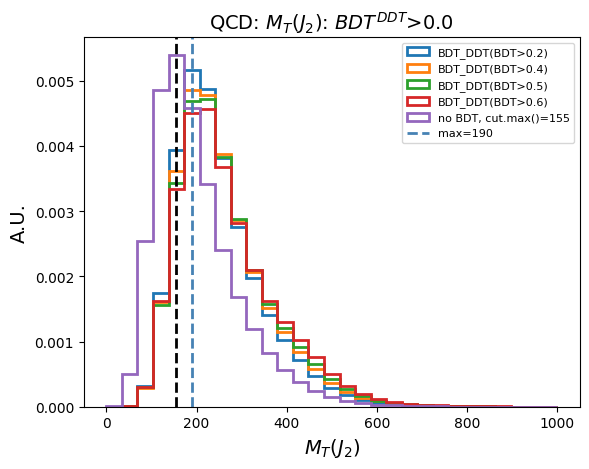

In [6]:
b=np.linspace(0,1000,30)
d=True
for i in (2,4,5,6):    
    plt.hist(QCD['mt'][BKG_score_ddt[i]['QCD']>0], bins=b, weights=QCD['weight'][BKG_score_ddt[i]['QCD']>0], histtype='step', linewidth=2, label=r'BDT_DDT(BDT>{:.1f})'.format(i/10), density=d)
plt.hist(QCD['mt'], bins=b, weights=QCD['weight'], histtype='step', linewidth=2, label='no BDT, cut.max()=155', density=d)
#plt.yscale('log')

plt.axvline(x=189.66, color='steelblue', linestyle='dashed', label='max=190', linewidth=2)
plt.axvline(x=155.17, color='black', linestyle='dashed', linewidth=2)
plt.legend()

plt.legend(fontsize=8)
plt.xlabel('$M_T(J_2)$',fontsize=14)
plt.ylabel('A.U.',fontsize=14)
plt.title('QCD: $M_T(J_2)$: $BDT^{DDT}$>0.0',fontsize=14)
#plt.savefig('png/ddt/noreweight/qcd_mt_bdtddtcuts_normalized.png')
#plt.savefig('png/ddt/noreweight/qcd_mt_bdtddtcuts.png')

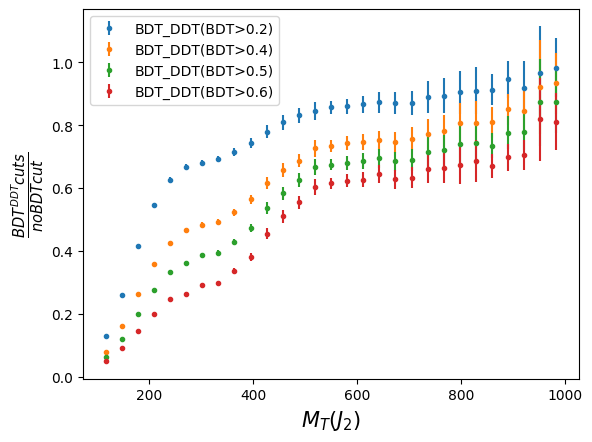

In [139]:
b=np.linspace(100,1000,30)

nref_err        = np.sqrt(np.histogram(QCD['mt'], bins=b, weights=QCD['weight']**2)[0])
val_ref         = np.histogram(QCD['mt'], bins=b, weights=QCD['weight'])[0]

for sc in (2,4,5,6):
    ncuts_err   = np.sqrt(np.histogram(QCD['mt'][BKG_score_ddt[sc]['QCD']>0], bins=b, weights=QCD['weight'][BKG_score_ddt[sc]['QCD']>0]**2)[0])
    val         = np.histogram(QCD['mt'][BKG_score_ddt[sc]['QCD']>0], bins=b, weights=QCD['weight'][BKG_score_ddt[sc]['QCD']>0])[0]
    ratio       = val/ val_ref
    bincenter   = 0.5 * (edge_ref[1:] + edge_ref[:-1])
    
    error = val/val_ref * np.sqrt((nref_err/val_ref)**2+(ncuts_err/val)**2)

    plt.errorbar(bincenter, ratio, yerr=error, fmt='.', label=r'BDT_DDT(BDT>{:.1f})'.format(sc/10))
    
    plt.xlabel('$M_T(J_2)$', fontsize=15)
    plt.ylabel(r'$\frac{BDT^{DDT} cuts}{no BDT cut}$', fontsize=15)
    plt.legend(loc='upper left')
    plt.savefig('png/ratioplot_bdtddt_over_nobdt.png')

In [ ]:
b=np.linspace(100,1000,30)

l1=np.histogram(QCD['mt'], bins=b, weights=QCD['weight'])
g=np.where(l1[0]==l1[0].max())[0].tolist(), 
m_l1=l1[1][g]+b[1]/2

l2=np.histogram(QCD['mt'][BKG_score_ddt[4]['QCD']>0], bins=b, weights=QCD['weight'][BKG_score_ddt[4]['QCD']>0])
g=np.where(l2[0]==l2[0].max())[0].tolist()
m_l2=l2[1][g]+b[1]/2
    
print(m_l1[0], m_l2[0])
plt.hist(QCD['mt'], bins=b, weights=QCD['weight'], histtype='step', linewidth=2, label='no BDT cut max={:.2f}'.format(m_l1[0]))
plt.axvline(x=m_l2[0], linewidth=2, color='black', linestyle='dashed', label='max={:.2f}'.format(m_l2[0]))

for i in range(1,6):    
    plt.hist(QCD['mt'][BKG_score_ddt[i]['QCD'][i]>0], bins=b, weights=QCD['weight'][BKG_score_ddt[i]['QCD'][i]>0], histtype='step', linewidth=2, label='BDT_DDT(BDT>{:.1f})'.format(i/10))
    
plt.yscale('log')
plt.legend(fontsize=8)
plt.xlabel('$M_T(J_2)$',fontsize=14)
plt.ylabel('A.U.',fontsize=14)
plt.title('QCD: $M_T(J_2)$: $BDT^{DDT}$>0.0',fontsize=14)
#plt.savefig('png/ddt/mt_bdtddt_cuts.png')

155.17241379310346


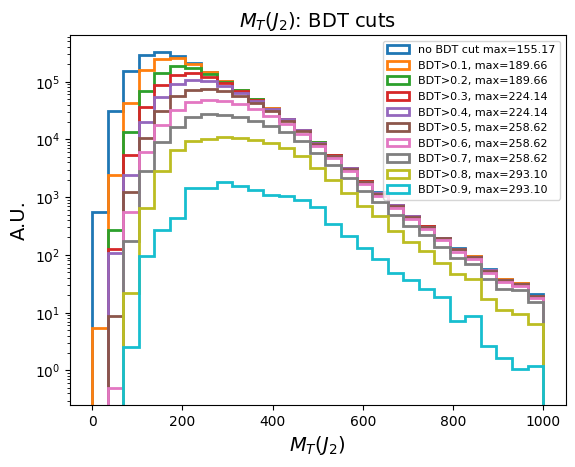

In [8]:
b=np.linspace(0,1000,30)

l1=np.histogram(QCD['mt'], bins=b, weights=QCD_weights)
g=np.where(l1[0]==l1[0].max())[0].tolist(), 
m_l1=l1[1][g]+b[1]/2
print(m_l1[0])
plt.hist(QCD['mt'], bins=b, weights=QCD_weights, histtype='step', linewidth=2, label='no BDT cut max={:.2f}'.format(m_l1[0]))
for i in range(1,10):
    l2=np.histogram(QCD['mt'][QCD_score>i/10], bins=b, weights=QCD_weights[QCD_score>i/10])
    g=np.where(l2[0]==l2[0].max())[0].tolist()
    m_l2=l2[1][g]+b[1]/2
    plt.hist(QCD['mt'][QCD_score>i/10], bins=b, weights=QCD_weights[QCD_score>i/10], histtype='step', linewidth=2, label='BDT>{:.1f}, max={:.2f}'.format(i/10, m_l2[0]))

plt.yscale('log')
plt.legend(fontsize=8)
plt.xlabel('$M_T(J_2)$',fontsize=14)
plt.ylabel('A.U.',fontsize=14)
plt.title('$M_T(J_2)$: BDT cuts',fontsize=14)
plt.savefig('png/ddt/mt_bdtcuts.png')


In [150]:
score_sig_ddt = {}
rhobin_sig = {}
ptbin_sig = {}
score_sig_map_smooth = {} 
RHO_sig_edges = {} 
PT_sig_edges = {}


sig_Hist={}
sig_eff={}

#for s in sig_label_rinv:
'''for s in sig_score.keys():
    eff=[]
    sig_Hist_tot=np.histogram(sig_score[s],weights=signal[s]['weight'])
    for i in range(10):
        sig_Hist=[]
        sig_Hist=np.histogram(sig_score[s][sig_score[s]>i/10],weights=signal[s]['weight'][sig_score[s]>i/10])
        eff.append(sum(sig_Hist[0])/sum(sig_Hist_tot[0]))
    sig_eff[s]=eff'''


'''for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):    
    score_sig_ddt[s]        = {}
    rhobin_sig[s]           = {}
    ptbin_sig[s]            = {}
    score_sig_map_smooth[s] = {} 
    RHO_sig_edges[s]        = {} 
    PT_sig_edges[s]         = {}
    #for i in range(9):
    for i in (3,4,5):
        score_sig_ddt[s][i+1], rhobin_sig[s][i+1], ptbin_sig[s][i+1], score_sig_map_smooth[s][i+1], RHO_sig_edges[s][i+1], PT_sig_edges[s][i+1] = ddt(signal[s]['mt'], signal[s]['pt'], signal[s]['rho'], bkg_score[0], sig_score[s], signal[s]['weight'], bkg_eff['QCD'][i+1]*100)
'''
        
        
#for cuts in (-1,3,4,5):
for cuts in (-1,0,1,2,3,4,5):
    score_sig_ddt[cuts+1]        = {}
    rhobin_sig[cuts+1]           = {}
    ptbin_sig[cuts+1]            = {}
    score_sig_map_smooth[cuts+1] = {} 
    RHO_sig_edges[cuts+1]        = {} 
    PT_sig_edges[cuts+1]         = {}
    for sig in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'): 
        score_sig_ddt[cuts+1][sig], rhobin_sig[cuts+1][sig], ptbin_sig[cuts+1][sig], score_sig_map_smooth[cuts+1][sig], RHO_sig_edges[cuts+1][sig], PT_sig_edges[cuts+1][sig] = ddt(signal[sig]['mt'], signal[sig]['pt'], signal[sig]['rho'], bkg_score[0], sig_score[sig], signal[sig]['weight'], bkg_eff['QCD'][cuts+1]*100)



[bdt:INFO:2023-06-07 23:01:05:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-06-07 23:02:15:common:47 hepcms-in1.umd.edu] Done (took 01m:9.95s)
[bdt:INFO:2023-06-07 23:02:15:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-06-07 23:03:25:common:47 hepcms-in1.umd.edu] Done (took 01m:9.14s)
[bdt:INFO:2023-06-07 23:03:25:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-06-07 23:04:35:common:47 hepcms-in1.umd.edu] Done (took 01m:10.24s)
[bdt:INFO:2023-06-07 23:04:35:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...77.76441450451608
[bdt:INFO:2023-06-07 23:05:41:common:47 hepcms-in1.umd.edu] Done (took 01m:6.41s)
[bdt:INFO:2023-06-07 23:05:41:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...77.76441450451608
[bdt:INFO:2023-06-07 23:06:50:common:47 hepcms-in1.umd.edu] Done (took 01m:8.32s)
[bdt:INFO:2023-06-07 23:06:50:common:40 hepcms-in1.umd.edu] Calculating ddt scores fo

In [147]:
json_file_rho = '/home/snabili/data/test/svj_uboost/models/svjbdt_Jun02_reweight_rho_allsignals_ttjets_refmz250.json'
json_file_mt  = '/home/snabili/data/test/svj_uboost/models/svjbdt_May24_reweight_mt_allsignals_qcdttjets_refmz250.json'

model_mt  = bdtcode.utils.get_model(json_file_mt)
model_rho = bdtcode.utils.get_model(json_file_rho)

for i in range(sig_length_rinv):
    signal[sig_label_rinv[i]]['rho_bdtscore'] = model_rho.predict_proba(np.transpose(sig_bdtfeatures[sig_label_rinv[i]]))[:,1]
    signal[sig_label_rinv[i]]['mt_bdtscore']  = model_mt.predict_proba(np.transpose(sig_bdtfeatures[sig_label_rinv[i]]))[:,1]

    

for i in range(sig_length_mdark):
    signal[sig_label_mdark[i]]['rho_bdtscore']    = model_rho.predict_proba(np.transpose(sig_bdtfeatures[sig_label_mdark[i]]))[:,1]
    signal[sig_label_mdark[i]]['mt_bdtscore']    = model_mt.predict_proba(np.transpose(sig_bdtfeatures[sig_label_mdark[i]]))[:,1]
    
QCD['rho_bdtscore']    = model_rho.predict_proba(np.transpose(QCD_bdtfeatures))[:,1]
TTJets['rho_bdtscore'] = model_rho.predict_proba(np.transpose(TTJets_bdtfeatures))[:,1]
WJets['rho_bdtscore']  = model_rho.predict_proba(np.transpose(WJets_bdtfeatures))[:,1]
ZJets['rho_bdtscore']  = model_rho.predict_proba(np.transpose(ZJets_bdtfeatures))[:,1]

QCD['mt_bdtscore']     = model_mt.predict_proba(np.transpose(QCD_bdtfeatures))[:,1]
TTJets['mt_bdtscore']  = model_mt.predict_proba(np.transpose(TTJets_bdtfeatures))[:,1]
WJets['mt_bdtscore']   = model_mt.predict_proba(np.transpose(WJets_bdtfeatures))[:,1]
ZJets['mt_bdtscore']   = model_mt.predict_proba(np.transpose(ZJets_bdtfeatures))[:,1]


def ROC_curve(data, w, var, var_min, var_max):
    general_cut=(data[var]>var_min)
    
    b=np.linspace(data[var][general_cut].min(), data[var][general_cut].max(),50)
    hist_general=plt.hist(data[var][general_cut], weights=w[general_cut], bins=b)
    tot = sum(hist_general[0])   
    var_cut = np.linspace(var_min, var_max,30)
    eff=[]
    for i in range(30):
        sr_cut=(data[var]>var_cut[i])
        hist_cut=plt.hist(data[var][sr_cut], weights=w[sr_cut], bins=b)
        single_eff = sum(hist_cut[0])     
        eff.append(single_eff/tot)

    plt.close()
    return eff

sig_rinv_eff = {}
sig_mdark_eff = {}
qcd_eff={}

lab_sig_rinv = ['BSVJ_'+str(i)+'_10_'+str(j)+'_peak' for i in np.arange(200,510,50) for j in ('0.1','0.3','0.7')]
lab_sig_mdark = ['BSVJ_'+str(i)+'_'+str(j)+'_0.3_peak' for i in np.arange(200,510,50) for j in ('1','5','10')]

for bdt_model in ('rho_bdtscore', 'mt_bdtscore'):
    qcd_eff[bdt_model] =ROC_curve(QCD, QCD['weight'], bdt_model, 0, 1)
    sig_rinv_eff[bdt_model]  = {}
    sig_mdark_eff[bdt_model]  = {}
    for k in range(3):
        for i in range(7):
            sig_rinv_eff[bdt_model][lab_sig_rinv[3*i+k]] = ROC_curve(signal[lab_sig_rinv[3*i+k]], signal[lab_sig_rinv[3*i+k]]['weight'], bdt_model, 0, 1)
            sig_mdark_eff[bdt_model][lab_sig_mdark[3*i+k]] = ROC_curve(signal[lab_sig_mdark[3*i+k]], signal[lab_sig_mdark[3*i+k]]['weight'], bdt_model, 0, 1)

In [275]:
Bincenter = {}
Ratio     = {}
for rew in ('rho_bdtscore', 'mt_bdtscore'):
    Bincenter[rew] = {}
    Ratio[rew]     = {}
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        Ratio[rew][s]     = {}
        Bincenter[rew][s] = {}
        for sc in (0.0, 0.4, 0.5, 0.6):
            Ratio[rew][s][sc], Bincenter[rew][s][sc] = ratio_plots(sc, rew, s)

color=['green','red','steelblue','black'] 
style=['P','o','*','p']
lab=[r'$\rho$-rew> ', '$M_T$-rew> ']
for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
    for sc in (0.4, 0.5, 0.6):
        l=0
        for rew in ('rho_bdtscore', 'mt_bdtscore'):
            plt.plot(Bincenter[rew][s][sc], Ratio[rew][s][sc], style[l], label=lab[l]+str(sc), color=color[l])
            l+=1
        plt.plot(bincenter_ddt[sc*10][s], ratio_ddt[sc*10][s], style[l], label='$BDT^{DDT}$> '+str(sc), color=color[l])
        l+=1
        plt.plot(Bincenter[rew][s][0], Ratio[rew][s][0], style[l], label='no BDT cut', color=color[l])
        plt.legend()
        plt.xlabel('$M_T(J_2)$', fontsize=15)  
        plt.ylabel(r'$S/\sqrt{B}$', fontsize=15)
        plt.title(s)
        plt.savefig('png/ddt/metrics/'+str(s)+'_'+str(sc)+'.png')
        plt.close()

In [79]:

#for i in (4, 5, 6):
for i in range(6):
    QCD['ddt_bdtscore_0.'+str(i)]    = BKG_score_ddt[i]['QCD']
    TTJets['ddt_bdtscore_0.'+str(i)] = BKG_score_ddt[i]['TTJets']
    WJets['ddt_bdtscore_0.'+str(i)]  = BKG_score_ddt[i]['WJets']
    ZJets['ddt_bdtscore_0.'+str(i)]  = BKG_score_ddt[i]['ZJets']
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        signal[s]['ddt_bdtscore_0.'+str(i)] = score_sig_ddt[i][s]
    

In [46]:
qcd_eff['ddt_bdtscore'] = ROC_curve(BKG_score_ddt[4], QCD['weight'], 'QCD', -1, 1)
for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'): 
    sig_rinv_eff['ddt_bdtscore_'+str(s)] = ROC_curve(score_sig_ddt[4], signal[s]['weight'], s, -1, 1)

In [152]:
def ration(val_sig, val_bkg):
    ratio = val_sig/np.sqrt(val_bkg)
    return ratio

def ratio_plots(sc, score, s):
    #b=np.linspace(QCD['mt'][QCD[score]>sc].min(),1000,30)
    b=np.linspace(100, 1000, 30)
    BKG = [ZJets['mt'][ZJets[score]>sc], WJets['mt'][WJets[score]>sc], TTJets['mt'][TTJets[score]>sc], QCD['mt'][QCD[score]>sc]]
    BKG_Weights = [ZJets['weight'][ZJets[score]>sc], WJets['weight'][WJets[score]>sc], TTJets['weight'][TTJets[score]>sc], QCD['weight'][QCD[score]>sc]]
    val_of_bins_x2, edges_of_bins_x2, patches_x2 = plt.hist(BKG, bins=b, weights=BKG_Weights, stacked=True)
    ratio[sc]            = {}
    bincenter[sc]        = {}
    val_of_bins_x1, edges_of_bins_x1, patches_x1 = plt.hist(signal[s]['mt'][signal[s][score]>sc],bins=b, weights=signal[s]['weight'][signal[s][score]>sc])
    plt.close()
    ratio[s+str(sc)] = ration(val_of_bins_x1, val_of_bins_x2[3])
    bincenter[s+str(sc)] = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])
    
    return ratio[s+str(sc)], bincenter[s+str(sc)]

In [154]:
#b=np.linspace(QCD['mt'].min(),1000,30)
b=np.linspace(100,1000,30)

BKG = [ZJets['mt'], WJets['mt'], TTJets['mt'], QCD['mt']]
BKG_Weights = [ZJets['weight'], WJets['weight'], TTJets['weight'], QCD['weight']]
                                           

val_of_bins_x2, edges_of_bins_x2, patches_x2 = a0.hist(BKG, bins=b, weights=BKG_Weights, stacked=True)#, label=['ZJets', 'WJets', 'TTJets', 'QCD'])
ratio_nocuts            = {}
bincenter_nocuts        = {}

for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
    val_of_bins_x1, edges_of_bins_x1, patches_x1 = a0.hist(signal[s]['mt'],bins=b, weights=signal[s]['weight'])#, histtype='step',linewidth=2, linestyle='dashed', label=s, color=colors[l])
    ratio_nocuts[s]     = ration(val_of_bins_x1, val_of_bins_x2[3])
    bincenter_nocuts[s] = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])
    plt.close()

In [153]:
ratio={}
bincenter={}

for score in ('rho_bdtscore', 'mt_bdtscore'):
    ratio[score] = {}
    bincenter[score] = {}
    for cuts in (0.4, 0.5, 0.6):
        ratio[score][cuts] = {}
        bincenter[score][cuts] = {}
        for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
            ratio[score][cuts][s], bincenter[score][cuts][s] =ratio_plots(cuts, score, s)


In [272]:
for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
    for cuts in (0.4, 0.5, 0.6):
        plt.plot(bincenter['rho_bdtscore'][cuts][s], ratio['rho_bdtscore'][cuts][s], 'P', label=r'$\rho$-rew> '+str(cuts), color='green')
        plt.plot(bincenter['mt_bdtscore'][cuts][s], ratio['mt_bdtscore'][cuts][s], 'o', label='$M_T$-rew> '+str(cuts), color='red')
        plt.plot(bincenter_ddt[cuts*10][s], ratio_ddt[cuts*10][s], '*', label='$BDT^{DDT}$> '+str(cuts), color='steelblue')
        plt.plot(bincenter_nocuts[s], ratio_nocuts[s], 'p', label='nocut', color='black')
        plt.legend()
        plt.xlabel('$M_T(J_2)$', fontsize=15)  
        plt.ylabel(r'$S/\sqrt{B}$', fontsize=15)
        plt.title(s)
        plt.savefig('png/ddt/metrics/'+str(s)+'_'+str(cuts)+'.png')
        plt.close()
    

KeyError: 0.4

In [295]:
d=False
for sc in (0,4,5,6):
    fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10,7))
    fig.subplots_adjust(hspace=0)
    b=np.linspace(100, 1000, 30)

    BKG = [ZJets['mt'][BKG_score_ddt[sc]['ZJets']>0], WJets['mt'][BKG_score_ddt[sc]['WJets']>0], TTJets['mt'][BKG_score_ddt[sc]['TTJets']>0], QCD['mt'][BKG_score_ddt[sc]['QCD']>0]]
    BKG_Weights = [ZJets['weight'][BKG_score_ddt[sc]['ZJets']>0], WJets['weight'][BKG_score_ddt[sc]['WJets']>0], TTJets['weight'][BKG_score_ddt[sc]['TTJets']>0], QCD['weight'][BKG_score_ddt[sc]['QCD']>0]]
                                           

    val_of_bins_x2, edges_of_bins_x2 = np.histogram(np.hstack(BKG), bins=b, weights=np.hstack(BKG_Weights))
    a0.hist(BKG, bins=b, weights=BKG_Weights, stacked=True, label=['ZJets', 'WJets', 'TTJets', 'QCD'], density=d)


    colors=['red', 'blue', 'cyan']
    l=0
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        val_of_bins_x1, edges_of_bins_x1 = np.histogram(signal[s]['mt'][score_sig_ddt[sc][s]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[sc][s]>0.0])
        a0.hist(signal[s]['mt'][score_sig_ddt[sc][s]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[sc][s]>0.0], histtype='step',linewidth=2, linestyle='dashed', label=s, color=colors[l], density=d)


        rat = ration(val_of_bins_x1, val_of_bins_x2[3])
        bincent = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])
        a1.plot(bincent, rat, '.', color=colors[l]) 
        l+=1
    a0.legend(fontsize=12)
    a0.set_yscale('log')
    a0.set_title('$M_T(J_2)$ $BDT^{DDT}>0.0, (BDT>0.$'+str(sc)+')', fontsize=15)
    a0.set_ylabel('A.U.', fontsize=15)

    a1.set_xlabel('$M_T(J_2)$', fontsize=15)
    a1.set_ylabel('$S/\sqrt{B}$', fontsize=15)
    a1.grid(True)
    a0.grid(True)
    plt.savefig('png/ddt/metrics/mt_sigbkgstacked_bdtddt_0.'+str(sc)+'.png')
    plt.close()
    
    

KeyError: 'rho_bdtscore'

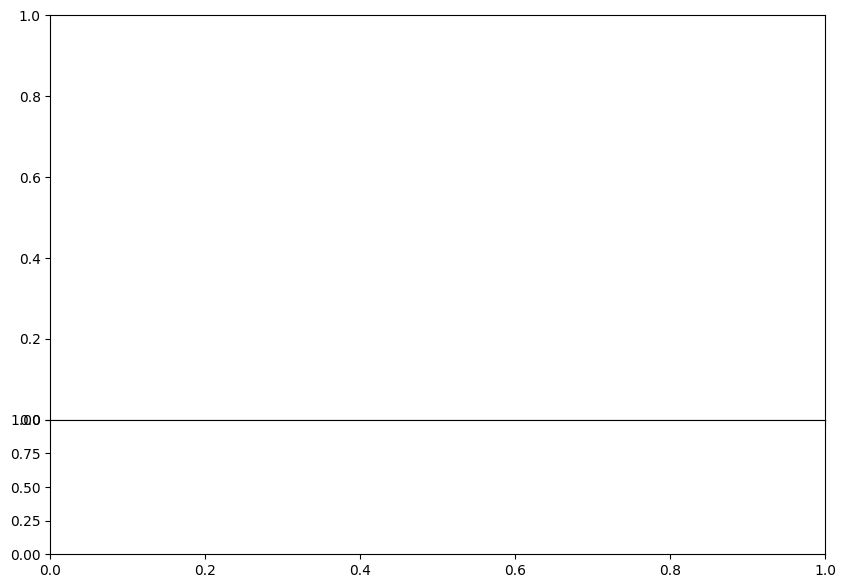

In [142]:
title=[r'$\rho$', '$M_T$']
d=False
g=0
for rew in ('rho_bdtscore', 'mt_bdtscore'):
    for sc in (0,4,5,6):
        fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10,7))
        fig.subplots_adjust(hspace=0)
        b=np.linspace(100, 1000, 30)

        BKG = [ZJets['mt'][ZJets[rew]>sc/10], WJets['mt'][WJets[rew]>sc/10], TTJets['mt'][TTJets[rew]>sc/10], QCD['mt'][QCD[rew]>sc/10]]
        BKG_Weights = [ZJets['weight'][ZJets[rew]>sc/10], WJets['weight'][WJets[rew]>sc/10], TTJets['weight'][TTJets[rew]>sc/10], QCD['weight'][QCD[rew]>sc/10]]


        val_of_bins_x2, edges_of_bins_x2 = np.histogram(np.hstack(BKG), bins=b, weights=np.hstack(BKG_Weights))
        a0.hist(BKG, bins=b, weights=BKG_Weights, stacked=True, label=['ZJets', 'WJets', 'TTJets', 'QCD'], density=d)


        colors=['red', 'blue', 'cyan']
        l=0
        for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
            val_of_bins_x1, edges_of_bins_x1 = np.histogram(signal[s]['mt'][score_sig_ddt[sc][s]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[sc][s]>0.0])
            a0.hist(signal[s]['mt'][signal[s][rew]>sc/10],bins=b, weights=signal[s]['weight'][signal[s][rew]>sc/10], histtype='step',linewidth=2, linestyle='dashed', label=s, color=colors[l], density=d)


            rat = val_of_bins_x1/np.sqrt(val_of_bins_x2[3])
            bincent = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])
            a1.plot(bincent, rat, '.', color=colors[l]) 
            l+=1
        rat=0
        bincent=0
        a0.legend(fontsize=12)
        a0.set_yscale('log')
        a0.set_title('$M_T(J_2)$ '+str(title[g])+' re-weight BDT>0.'+str(sc), fontsize=15)
        a0.set_ylabel('A.U.', fontsize=15)

        a1.set_xlabel('$M_T(J_2)$', fontsize=15)
        a1.set_ylabel('$S/\sqrt{B}$', fontsize=15)
        a1.grid(True)
        a0.grid(True)
        #plt.savefig('png/ddt/metrics/mt_sigbkgstacked_bdt_'+str(rew)+'_0.'+str(sc)+'.png')
        #plt.close()
    g+=1
    
    

In [242]:
for i in (0,4,5,6):
    print('BDT>0.',i)
    print('  BSVJ_250_10_0.3: {:.2f}'.format(n[i]['BSVJ_250_10_0.3_peak'][4]/np.sqrt(nb[i][4])))
    print('  BSVJ_350_10_0.3: {:.2f}'.format(n[i]['BSVJ_350_10_0.3_peak'][6]/np.sqrt(nb[i][6])))
    print('  BSVJ_450_10_0.3: {:.2f}'.format(n[i]['BSVJ_450_10_0.3_peak'][9]/np.sqrt(nb[i][9])))





BDT>0. 0
  BSVJ_250_10_0.3: 5.11
  BSVJ_350_10_0.3: 5.68
  BSVJ_450_10_0.3: 5.65
BDT>0. 4
  BSVJ_250_10_0.3: 5.92
  BSVJ_350_10_0.3: 6.39
  BSVJ_450_10_0.3: 6.08
BDT>0. 5
  BSVJ_250_10_0.3: 6.06
  BSVJ_350_10_0.3: 6.48
  BSVJ_450_10_0.3: 6.08
BDT>0. 6
  BSVJ_250_10_0.3: 6.23
  BSVJ_350_10_0.3: 6.57
  BSVJ_450_10_0.3: 6.01


In [225]:
b=np.linspace(100, 1000, 30)

nb={}
n={}

for sc in (0,4,5,6):
    print('cut=', sc)
    BKG = [ZJets['mt'][BKG_score_ddt[sc]['ZJets']>0], WJets['mt'][BKG_score_ddt[sc]['WJets']>0], TTJets['mt'][BKG_score_ddt[sc]['TTJets']>0], QCD['mt'][BKG_score_ddt[sc]['QCD']>0]]
    BKG_Weights = [ZJets['weight'][BKG_score_ddt[sc]['ZJets']>0], WJets['weight'][BKG_score_ddt[sc]['WJets']>0], TTJets['weight'][BKG_score_ddt[sc]['TTJets']>0], QCD['weight'][BKG_score_ddt[sc]['QCD']>0]]
    nb[sc], bbins = np.histogram(np.hstack(BKG), bins=b, weights=np.hstack(BKG_Weights))
    bmids = 0.5*(bbins[1:] + bbins[:-1])
    bmean = np.average(bmids, weights=nb[sc])
    bstd = np.sqrt(np.average((bmids - bmean)**2, weights=nb[sc]))
    print('   bkg,  std={:.2f}'.format(bstd))
    n[sc]={}
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'): 
        n[sc][s], bins = np.histogram(signal[s]['mt'][score_sig_ddt[sc][s]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[sc][s]>0.0])
        mids = 0.5*(bins[1:] + bins[:-1])
        mean = np.average(mids, weights=n[sc][s])
        std = np.sqrt(np.average((mids - mean)**2, weights=n[sc][s]))
        print('     signal=', s, ' std={:.2f}'.format(std))

                                                       
                                                       
                                                       

cut= 0
   bkg,  std=93.35
     signal= BSVJ_250_10_0.3_peak  std=107.97
     signal= BSVJ_350_10_0.3_peak  std=111.33
     signal= BSVJ_450_10_0.3_peak  std=123.46
cut= 4
   bkg,  std=103.79
     signal= BSVJ_250_10_0.3_peak  std=107.89
     signal= BSVJ_350_10_0.3_peak  std=108.94
     signal= BSVJ_450_10_0.3_peak  std=121.11
cut= 5
   bkg,  std=106.93
     signal= BSVJ_250_10_0.3_peak  std=108.43
     signal= BSVJ_350_10_0.3_peak  std=108.66
     signal= BSVJ_450_10_0.3_peak  std=121.10
cut= 6
   bkg,  std=111.43
     signal= BSVJ_250_10_0.3_peak  std=108.82
     signal= BSVJ_350_10_0.3_peak  std=109.57
     signal= BSVJ_450_10_0.3_peak  std=121.60


In [268]:
def ration(val_sig, val_bkg):
    ratio = val_sig/np.sqrt(val_bkg)
    return ratio


d=True
for sc in (0,4,5,6):
    fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10,7))
    fig.subplots_adjust(hspace=0)
    b=np.linspace(100, 1000, 30)

    BKG = np.hstack([ZJets['mt'][BKG_score_ddt[sc]['ZJets']>0], WJets['mt'][BKG_score_ddt[sc]['WJets']>0], TTJets['mt'][BKG_score_ddt[sc]['TTJets']>0], QCD['mt'][BKG_score_ddt[sc]['QCD']>0]])
    BKG_Weights = np.hstack([ZJets['weight'][BKG_score_ddt[sc]['ZJets']>0], WJets['weight'][BKG_score_ddt[sc]['WJets']>0], TTJets['weight'][BKG_score_ddt[sc]['TTJets']>0], QCD['weight'][BKG_score_ddt[sc]['QCD']>0]])
                                           

    val_of_bins_x2, edges_of_bins_x2 = np.histogram(BKG, bins=b, weights=BKG_Weights)

    a0.hist(BKG, bins=b, weights=BKG_Weights, label='BKG', histtype='step',linewidth=2, density=d)
    colors=['red', 'green', 'purple']
    l=0
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        val_of_bins_x1, edges_of_bins_x1 = np.histogram(signal[s]['mt'][score_sig_ddt[sc][s]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[sc][s]>0.0])
        a0.hist(signal[s]['mt'][score_sig_ddt[sc][s]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[sc][s]>0.0], histtype='step',linewidth=2, linestyle='dashed', label=s, color=colors[l], density=d)


        rat     = ration(val_of_bins_x1, val_of_bins_x2)
        bincent = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])
        a1.plot(bincent, rat, '.', color=colors[l]) 
        l+=1
    a0.legend(fontsize=12)
    #a0.set_yscale('log')
    a0.set_title('$M_T(J_2)$ $BDT^{DDT}>0.0, (BDT>0.$'+str(sc)+')', fontsize=15)
    a0.set_ylabel('A.U.', fontsize=15)

    a1.set_xlabel('$M_T(J_2)$', fontsize=15)
    a1.set_ylabel('$S/\sqrt{B}$', fontsize=15)
    a1.grid(True)
    a0.grid(True)
    plt.savefig('png/ddt/metrics/norm_mt_sigbkg_bdtddt_0.'+str(sc)+'.png')
    plt.close()
    
    

KeyError: 'rho_bdtscore'

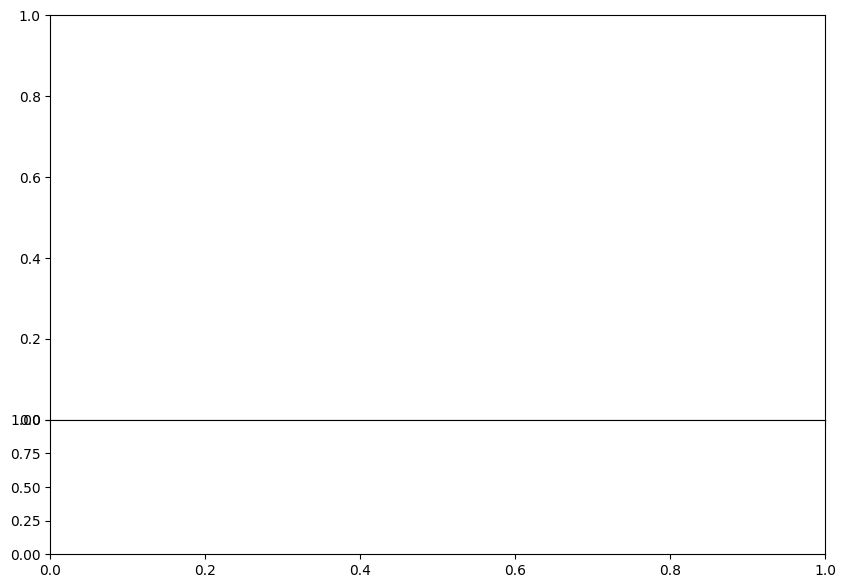

In [144]:
def ration(val_sig, val_bkg):
    ratio = val_sig/np.sqrt(val_bkg)
    return ratio

title=[r'$\rho(J_2)$', '$M_T(J_2)$']
n=0
d=True

cuts = [(0,0.4,0.42, 0.475), (0,0.4,0.43, 0.495), (0,0.4,0.485, 0.6)]

for rew in ('rho_bdtscore', 'mt_bdtscore'):
    #for sc in (0,4,5,6):
    for sc in cuts[n]:
        fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10,7))
        fig.subplots_adjust(hspace=0)
        b=np.linspace(100, 1000, 30)

        BKG = np.hstack([ZJets['mt'][ZJets[rew]>sc/10], WJets['mt'][WJets[rew]>sc/10], TTJets['mt'][TTJets[rew]>sc/10], QCD['mt'][QCD[rew]>sc/10]])
        BKG_Weights = np.hstack([ZJets['weight'][ZJets[rew]>sc/10], WJets['weight'][WJets[rew]>sc/10], TTJets['weight'][TTJets[rew]>sc/10], QCD['weight'][QCD[rew]>sc/10]])


        val_of_bins_x2, edges_of_bins_x2 = np.histogram(BKG, bins=b, weights=BKG_Weights)

        a0.hist(BKG, bins=b, weights=BKG_Weights, label='BKG', histtype='step',linewidth=2, density=d)
        colors=['red', 'green', 'purple']
        l=0
        for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
            val_of_bins_x1, edges_of_bins_x1 = np.histogram(signal[s]['mt'][signal[s][rew]>sc/10],bins=b, weights=signal[s]['weight'][signal[s][rew]>sc/10])
            a0.hist(signal[s]['mt'][signal[s][rew]>sc/10],bins=b, weights=signal[s]['weight'][signal[s][rew]>sc/10], histtype='step',linewidth=2, linestyle='dashed', label=s, color=colors[l], density=d)


            rat     = ration(val_of_bins_x1, val_of_bins_x2)
            bincent = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])
            a1.plot(bincent, rat, '.', color=colors[l]) 
            l+=1
        a0.legend(fontsize=12)
        #a0.set_yscale('log')
        a0.set_title('$M_T(J_2)$ '+title[n]+' re-weight: BDT>0.'+str(sc), fontsize=15)
        a0.set_ylabel('A.U.', fontsize=15)

        a1.set_xlabel('$M_T(J_2)$', fontsize=15)
        a1.set_ylabel('$S/\sqrt{B}$', fontsize=15)
        a1.grid(True)
        a0.grid(True)
        plt.savefig('png/ddt/metrics/norm_mt_sigbkg_'+str(rew)+'_0.'+str(sc)+'.png')
        plt.close()
    n+=1
    
    

NameError: name 'score_sig_ddt' is not defined

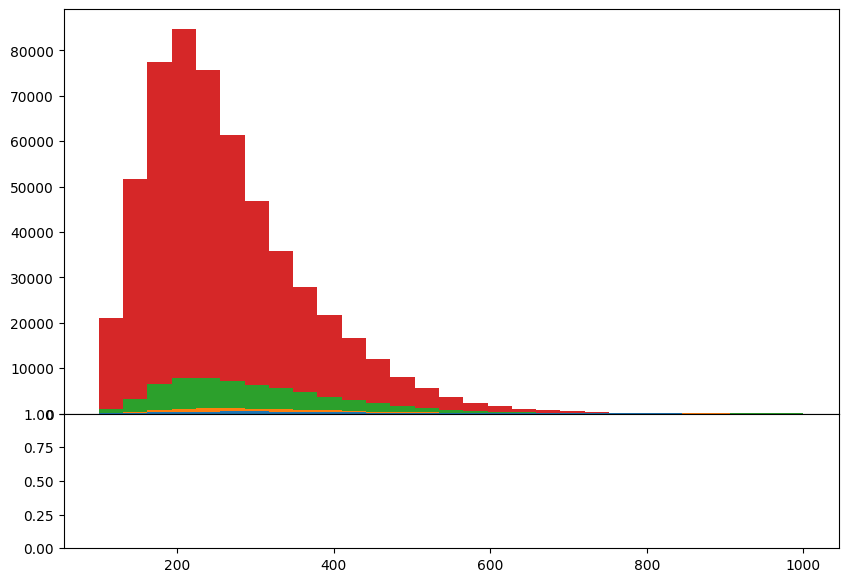

In [149]:
def ration(val_sig, val_bkg):
    ratio = val_sig/np.sqrt(val_bkg)
    return ratio


ratio_ddt        = {}
bincenter_ddt    = {}
for sc in (4,5,6):
    fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10,7))
    fig.subplots_adjust(hspace=0)
    #b=np.linspace(QCD['mt'][BKG_score_ddt[sc]['QCD']>0].min(),1000,30)
    b=np.linspace(100, 1000, 30)

    BKG = [ZJets['mt'][BKG_score_ddt[sc]['ZJets']>0], WJets['mt'][BKG_score_ddt[sc]['WJets']>0], TTJets['mt'][BKG_score_ddt[sc]['TTJets']>0], QCD['mt'][BKG_score_ddt[sc]['QCD']>0]]
    BKG_Weights = [ZJets['weight'][BKG_score_ddt[sc]['ZJets']>0], WJets['weight'][BKG_score_ddt[sc]['WJets']>0], TTJets['weight'][BKG_score_ddt[sc]['TTJets']>0], QCD['weight'][BKG_score_ddt[sc]['QCD']>0]]
                                           

    val_of_bins_x2, edges_of_bins_x2, patches_x2 = a0.hist(BKG, bins=b, weights=BKG_Weights, stacked=True, label=['ZJets', 'WJets', 'TTJets', 'QCD'])
    val_of_bins_x1   = {}
    edges_of_bins_x1 = {}
    ratio_ddt[sc]    = {}
    bincenter_ddt[sc]= {}

    colors=['red', 'blue', 'cyan']
    l=0
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        val_of_bins_x1[s], edges_of_bins_x1[s], patches_x1 = a0.hist(signal[s]['mt'][score_sig_ddt[sc][s]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[sc][s]>0.0], histtype='step',linewidth=2, linestyle='dashed', label=s, color=colors[l])


        ratio_ddt[sc][s]     = ration(val_of_bins_x1[s], val_of_bins_x2[3])
        bincenter_ddt[sc][s] = 0.5 * (edges_of_bins_x1[s][1:] + edges_of_bins_x1[s][:-1])
        a1.plot(bincenter_ddt[sc][s], ratio_ddt[sc][s], '.', color=colors[l]) 
        l+=1
    a0.legend(fontsize=12)
    a0.set_yscale('log')
    a0.set_title('$M_T(J_2)$ $BDT^{DDT}>0.0, (BDT>0.$'+str(sc)+')', fontsize=15)
    a0.set_ylabel('A.U.', fontsize=15)

    a1.set_xlabel('$M_T(J_2)$', fontsize=15)
    a1.set_ylabel('$S/\sqrt{B}$', fontsize=15)
    a1.grid(True)
    a0.grid(True)
    #plt.savefig('png/ddt/noreweight/mt_sigbkgstacked_bdt0.'+str(sc)+'.png')
    plt.close()
    
    

In [115]:



for i in range(4, 7):
    b=np.linspace(BKG_score_ddt['QCD'][i].min(), BKG_score_ddt['QCD'][i].max(),30)
    plt.hist(BKG_score_ddt['QCD'][i], bins=b, weights=QCD['weight'], linewidth=2, histtype='step', label='QCD')
    plt.hist(BKG_score_ddt['TTJets'][i], bins=b, weights=TTJets['weight'], linewidth=2, histtype='step', label='TTJets')
    plt.hist(score_sig_ddt['BSVJ_250_10_0.3_peak'][i], bins=b, weights=signal['BSVJ_250_10_0.3_peak']['weight'], linewidth=2, histtype='step', label='BSVJ_250_10_0.3_peak')
    plt.hist(score_sig_ddt['BSVJ_350_10_0.3_peak'][i], bins=b, weights=signal['BSVJ_350_10_0.3_peak']['weight'], linewidth=2, histtype='step', label='BSVJ_350_10_0.3_peak')
    plt.hist(score_sig_ddt['BSVJ_450_10_0.3_peak'][i], bins=b, weights=signal['BSVJ_450_10_0.3_peak']['weight'], linewidth=2, histtype='step', label='BSVJ_450_10_0.3_peak')
    plt.axvline(x=0.0, linestyle='dashed', linewidth=2, color='black')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('$BDT^{DDT}$')
    plt.ylabel('A.U.')
    plt.title('$BDT^{DDT}$ dist,  BDT>0.'+str(i)+' (bkg_eff={:.2f}%)'.format(bkg_eff['QCD'][i]))
    plt.savefig('png/ddt/noreweight/bdtddt_bdt0.'+str(i)+'.png')
    plt.close()
    

In [126]:
def ration(val_sig, val_bkg):
    ratio = val_sig/np.sqrt(val_bkg)
    return ratio



for sc in (4,5,6):
    fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10,7))
    fig.subplots_adjust(hspace=0)
    b=np.linspace(QCD['mt'][BKG_score_ddt['QCD'][sc]>0].min(),1000,30)

    BKG = [ZJets['mt'][BKG_score_ddt['ZJets'][sc]>0], WJets['mt'][BKG_score_ddt['WJets'][sc]>0], TTJets['mt'][BKG_score_ddt['TTJets'][sc]>0], QCD['mt'][BKG_score_ddt['QCD'][sc]>0]]
    BKG_Weights = [ZJets['weight'][BKG_score_ddt['ZJets'][sc]>0], WJets['weight'][BKG_score_ddt['WJets'][sc]>0], TTJets['weight'][BKG_score_ddt['TTJets'][sc]>0], QCD['weight'][BKG_score_ddt['QCD'][sc]>0]]
                                           

    val_of_bins_x2, edges_of_bins_x2, patches_x2 = a0.hist(BKG, bins=b, weights=BKG_Weights, stacked=True, label=['ZJets', 'WJets', 'TTJets', 'QCD'])
    val_of_bins_x1   = {}
    edges_of_bins_x1 = {}
    ratio            = {}
    bincenter        = {}

    colors=['red', 'blue', 'cyan']
    l=0
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        val_of_bins_x1[s], edges_of_bins_x1[s], patches_x1 = a0.hist(signal[s]['mt'][score_sig_ddt[s][sc]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[s][sc]>0.0], histtype='step',linewidth=2, linestyle='dashed', label=s, color=colors[l])


        ratio[s] = ration(val_of_bins_x1[s], val_of_bins_x2[3])
        bincenter[s] = 0.5 * (edges_of_bins_x1[s][1:] + edges_of_bins_x1[s][:-1])
        a1.plot(bincenter[s], ratio[s], '.', color=colors[l]) 
        l+=1
    a0.legend(fontsize=12)
    a0.set_yscale('log')
    a0.set_title('$M_T(J_2)$ $BDT^{DDT}>0.0, (BDT>0.$'+str(sc)+')', fontsize=15)
    a0.set_ylabel('A.U.', fontsize=15)

    a1.set_xlabel('$M_T(J_2)$', fontsize=15)
    a1.set_ylabel('$S/\sqrt{B}$', fontsize=15)
    a1.grid(True)
    a0.grid(True)
    plt.savefig('png/ddt/revised_mt_sigbkgstacked_bdt0.'+str(sc)+'.png')
    plt.close()
    
    

In [11]:
B={}
S={}
for i in range(10):
    cut = QCD_score > i/10
    B['bdt>0.'+str(i)] = np.histogram(QCD_score[cut], bins=40, weights=QCD_weights[cut])
    S['bdt>0.'+str(i)] = {}
    for j in range(sig_length_rinv):
        cut_sig = sig_score[sig_label_rinv[j]] > i/10
        s = np.histogram(sig_score[sig_label_rinv[j]][cut_sig], bins=40, weights=sig_weight[sig_label_rinv[j]][cut_sig])
        S['bdt>0.'+str(i)][sig_label_rinv[j]] = s
    for j in range(sig_length_mdark):
        cut_sig = sig_score[sig_label_mdark[j]] > i/10
        s = np.histogram(sig_score[sig_label_mdark[j]][cut_sig], bins=40, weights=sig_weight[sig_label_mdark[j]][cut_sig])
        S['bdt>0.'+str(i)][sig_label_mdark[j]] = s

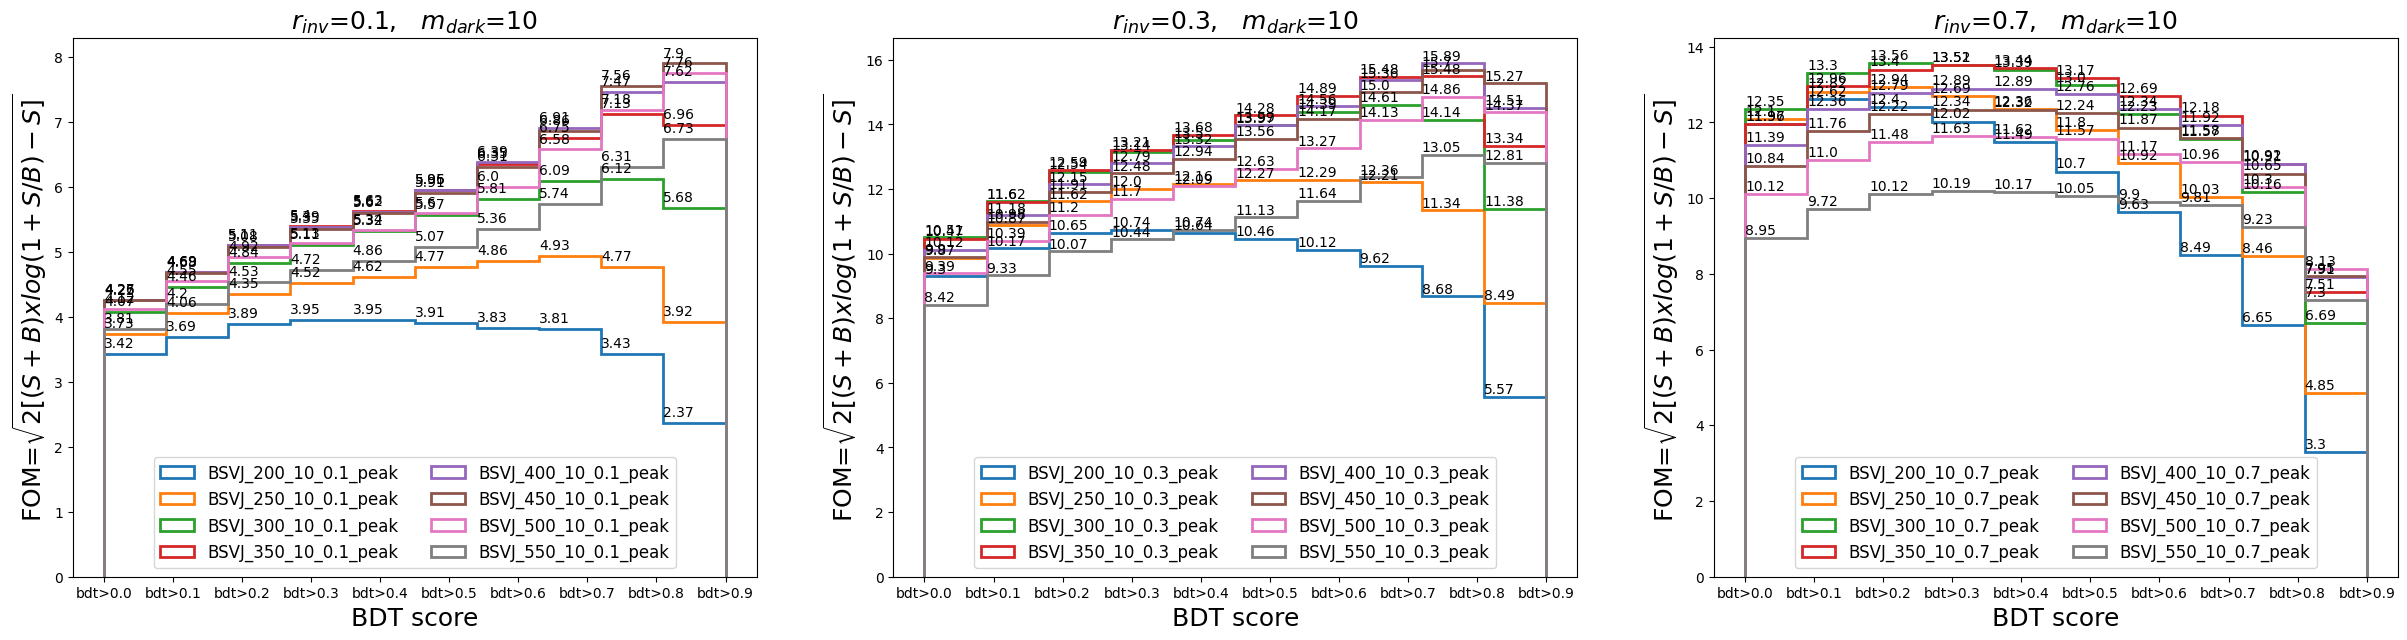

In [12]:
def FOM(s, b):
    FOM = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
    return FOM

def addlabels(arr, y_shift, rou):
    for i in range(len(arr[0])):
            plt.text(arr[1][i],arr[0][i]+y_shift,str(round(arr[0][i],rou)))

fom = {}
for i in B.keys():
    fom[i] = {}
    for j in sig_label_rinv:
        fom[i][j] = FOM(sum(S[i][j][0]), sum(B[i][0]))
    for j in sig_label_mdark:
        fom[i][j] = FOM(sum(S[i][j][0]), sum(B[i][0]))
f={}
for j in sig_label_rinv:
    f[j]=[fom[i][j] for i in B.keys()]
    
for j in sig_label_mdark:
    f[j]=[fom[i][j] for i in B.keys()]

g=1
r=1
c=3
fig=plt.figure(figsize=(30,7))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


        
L = ['bdt>0.0', 'bdt>0.1', 'bdt>0.2', 'bdt>0.3', 'bdt>0.4', 'bdt>0.5', 'bdt>0.6', 'bdt>0.7', 'bdt>0.8', 'bdt>0.9']
title = ['$r_{inv}$=0.1', '$r_{inv}$=0.3', '$r_{inv}$=0.7']
d = np.arange(0,1,0.1)
for k in range(3):
    fig.add_subplot(r, c, g)
    for i in range(8):
        arr=plt.hist(L, bins=10, weights=f[sig_label_rinv[3*i+k]], histtype='step', linewidth=2,label=sig_label_rinv[3*i+k])
        addlabels(arr, 0.1, 2)
        plt.xlabel('BDT score',fontsize=18)
        plt.ylabel('FOM=$\sqrt{2[(S+B) x log(1+S/B)-S]}$',fontsize=18)
        plt.legend(loc='lower center', ncol=2,fontsize=12)
    plt.title(title[k]+',   $m_{dark}$=10', fontsize=18)
    g+=1
plt.savefig('png/ddt/fom_rinv.png')

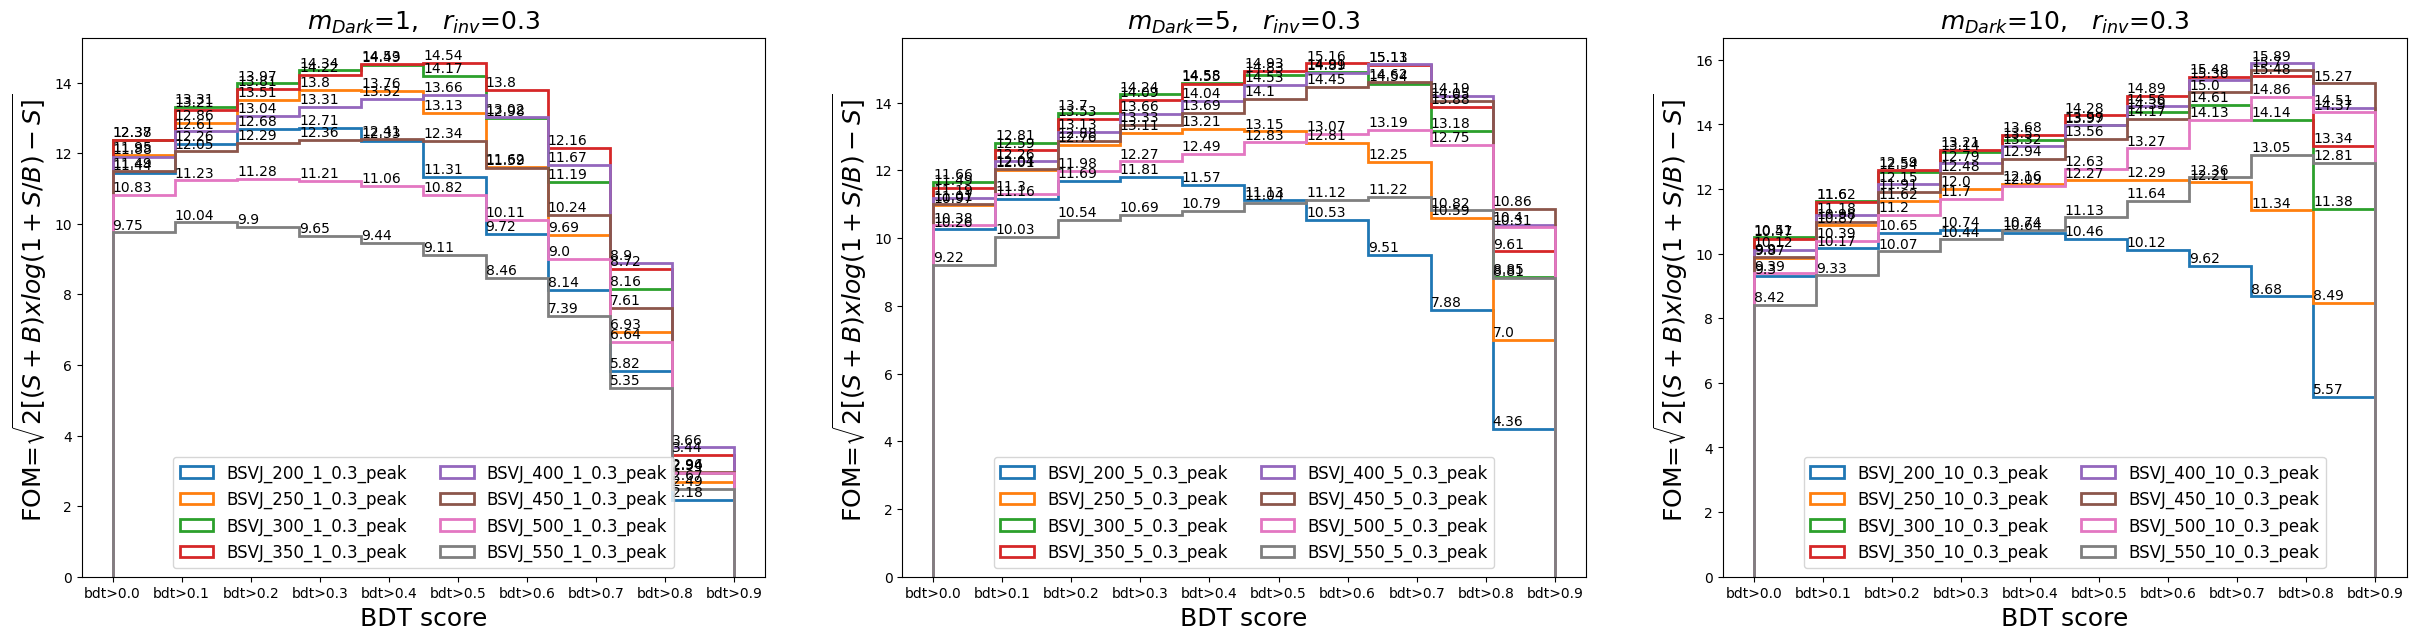

In [13]:
g=1
r=1
c=3
fig=plt.figure(figsize=(30,7))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


        
L = ['bdt>0.0', 'bdt>0.1', 'bdt>0.2', 'bdt>0.3', 'bdt>0.4', 'bdt>0.5', 'bdt>0.6', 'bdt>0.7', 'bdt>0.8', 'bdt>0.9']
title = ['$m_{Dark}$=1', '$m_{Dark}$=5', '$m_{Dark}$=10']
d = np.arange(0,1,0.1)
for k in range(3):
    fig.add_subplot(r, c, g)
    for i in range(8):
        arr=plt.hist(L, bins=10, weights=f[sig_label_mdark[3*i+k]], histtype='step', linewidth=2,label=sig_label_mdark[3*i+k])
        addlabels(arr, 0.1, 2)
        plt.xlabel('BDT score',fontsize=18)
        plt.ylabel('FOM=$\sqrt{2[(S+B) x log(1+S/B)-S]}$',fontsize=18)
        plt.legend(loc='lower center', ncol=2,fontsize=12)
    plt.title(title[k]+',   $r_{inv}$=0.3', fontsize=18)
    g+=1
plt.savefig('png/ddt/fom_mdark.png')

In [14]:
def ROC_curve(data, w, var, var_min, var_max):
    #print(var_min)
    general_cut=(data[var]>var_min)
    
    b=np.linspace(data[var][general_cut].min(), data[var][general_cut].max(),50)
    hist_general=plt.hist(data[var][general_cut], weights=w[general_cut], bins=b)
    tot = sum(hist_general[0])# * (s1[1][1:]-s1[1][:-1]))    
    var_cut = np.linspace(var_min, var_max,30)
    eff=[]
    for i in range(30):
        sr_cut=(data[var]>var_cut[i])
        hist_cut=plt.hist(data[var][sr_cut], weights=w[sr_cut], bins=b)
        single_eff = sum(hist_cut[0])     
        eff.append(single_eff/tot)

    plt.close()
    return eff

qcd_roc={}    
qcd_roc['qcd_score']= QCD_score
qcd_roc['qcd_score_ddt']=[BKG_score_ddt['QCD'][i] for i in range(1,10)]
#qcd_roc['qcd_score_ddt'] = [QCD_score_ddt[i] for i in range(1,10)]
qcd_eff =ROC_curve(qcd_roc, QCD_weights, 'qcd_score', -1, 1)
    
sig_roc_rinv  = {}
sig_roc_mdark  = {}
sig_rinv_eff  = {}
sig_mdark_eff  = {}

lab_sig_rinv = ['BSVJ_'+str(i)+'_10_'+str(j)+'_peak' for i in np.arange(200,510,50) for j in ('0.1','0.3','0.7')]
lab_sig_mdark = ['BSVJ_'+str(i)+'_'+str(j)+'_0.3_peak' for i in np.arange(200,510,50) for j in ('1','5','10')]

for k in range(3):
    for i in range(7):
        sig_roc_rinv[lab_sig_rinv[3*i+k]]  = {}
        sig_roc_rinv[lab_sig_rinv[3*i+k]]['sig_score']   = sig_score[lab_sig_rinv[3*i+k]]
        sig_roc_rinv[lab_sig_rinv[3*i+k]]['score_sig_ddt']   = [score_sig_ddt[lab_sig_rinv[3*i+k]][j] for j in range(1,10)]
        
        sig_roc_mdark[lab_sig_mdark[3*i+k]]  = {}
        sig_roc_mdark[lab_sig_mdark[3*i+k]]['sig_score']   = sig_score[lab_sig_mdark[3*i+k]]
        sig_roc_mdark[lab_sig_mdark[3*i+k]]['score_sig_ddt']   = [score_sig_ddt[lab_sig_mdark[3*i+k]][j] for j in range(1,10)] 
        
    for i in range(7):
        sig_rinv_eff[lab_sig_rinv[3*i+k]] = ROC_curve(sig_roc_rinv[lab_sig_rinv[3*i+k]], sig_weight[lab_sig_rinv[3*i+k]], 'sig_score', -1, 1)
        sig_mdark_eff[lab_sig_mdark[3*i+k]] = ROC_curve(sig_roc_mdark[lab_sig_mdark[3*i+k]], sig_weight[lab_sig_mdark[3*i+k]], 'sig_score', -1, 1)
    

In [25]:
models = {'BDT' : '/home/snabili/data/test/svj_uboost/models/svjbdt_May25_allsignals_qcdttjets.json'}
from collections import OrderedDict
scores = {}
aucs = {}

training_features = [
    'girth', 'ptd', 'axismajor', 'axisminor',
    'ecfm2b1', 'ecfd2b1', 'ecfc2b1', 'ecfn2b2', 'metdphi'
    ]

datadir = '/home/snabili/hadoop/HADD_puweight/'
from svj_ntuple_processing import Columns

qcd_cols = [Columns.load(f) for f in glob.glob(datadir+'/bkg/Summer20UL18/QCD_*.npz')]
#qcd_cols = list(filter(lambda c: c.metadata['ptbin'][0]>=300., qcd_cols))
ttjets_cols = [Columns.load(f) for f in glob.glob(datadir+'/bkg/Summer20UL18/TTJets_*.npz')]
bkg_cols = qcd_cols + ttjets_cols
#signal_cols = [Columns.load(f) for f in glob.glob(datadir+'/signal_notruth/madpt*.npz')]
signal_cols = [Columns.load(f) for f in glob.glob(datadir+'/signal_notruth/madpt300_mz350_mdark10_rinv0.3.npz')]

X, y, weight = columns_to_numpy(signal_cols, bkg_cols, features=training_features, downsample=1.)

# xgboost
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

score=[]
aucurv=[]

for key, model_file in models.items():
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(model_file)
    with time_and_log(f'Calculating xgboost scores for {key}...'):
        score     = xgb_model.predict_proba(X)[:,1]
        aucurv    = roc_auc_score(y, score, sample_weight=weight)

    

all_features = training_features + ['mt', 'rho', 'pt']

    
eff_BKG, eff_SIG, cuts = roc_curve(y, score, sample_weight=weight)

i_wp = np.argmax(eff_BKG >= bkg_eff['QCD'][4])
print(f'eff_sig: {eff_SIG[i_wp]:.3f}, bkg_eff: {eff_BKG[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')
i_wp = np.argmax(eff_BKG >= bkg_eff['QCD'][5])
print(f'eff_sig: {eff_SIG[i_wp]:.3f}, bkg_eff: {eff_BKG[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')
i_wp = np.argmax(eff_BKG >= bkg_eff['QCD'][6])
print(f'eff_sig: {eff_SIG[i_wp]:.3f}, bkg_eff: {eff_BKG[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

[bdt:INFO:2023-05-30 19:58:45:common:248 hepcms-in1.umd.edu] Downsampling bkg, keeping fraction of 1.0
[bdt:INFO:2023-05-30 19:58:48:common:40 hepcms-in1.umd.edu] Calculating xgboost scores for BDT...
[bdt:INFO:2023-05-30 19:59:35:common:47 hepcms-in1.umd.edu] Done (took 00m:47.51s)


eff_sig: 0.806, bkg_eff: 0.380, cut: 0.402
eff_sig: 0.727, bkg_eff: 0.284, cut: 0.501
eff_sig: 0.631, bkg_eff: 0.197, cut: 0.602


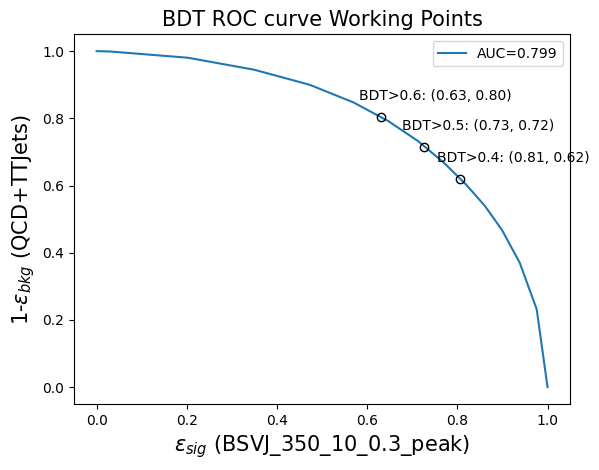

In [26]:
AUC =auc(sig_rinv_eff[lab_sig_rinv[10]], np.ones_like(qcd_eff)-qcd_eff)
plt.plot(sig_rinv_eff[lab_sig_rinv[10]], np.ones_like(qcd_eff)-qcd_eff, label='AUC={:.3f}'.format(AUC))
plt.legend()

x=[]
y=[]
for i in (4,5,6):
    i_wp=np.argmax(eff_BKG >= bkg_eff['QCD'][i])
    x.append(eff_SIG[i_wp])
    y.append(1-eff_BKG[i_wp])

plt.plot(x,y,'o',mfc='none',color='black')

for i in range(3):
    plt.annotate('BDT>0.{:d}: ({:.2f}, {:.2f})'.format(i+4, x[i],y[i]), xy=(x[i], y[i]), xytext=(x[i]-0.05, y[i]+0.05))

plt.xlabel('$\epsilon_{sig}$ ('+lab_sig_rinv[10]+')', fontsize=15)
plt.ylabel('1-$\epsilon_{bkg}$ (QCD+TTJets)', fontsize=15)
plt.title('BDT ROC curve Working Points', fontsize=15)
plt.savefig('png/ddt/roc_wp.png')

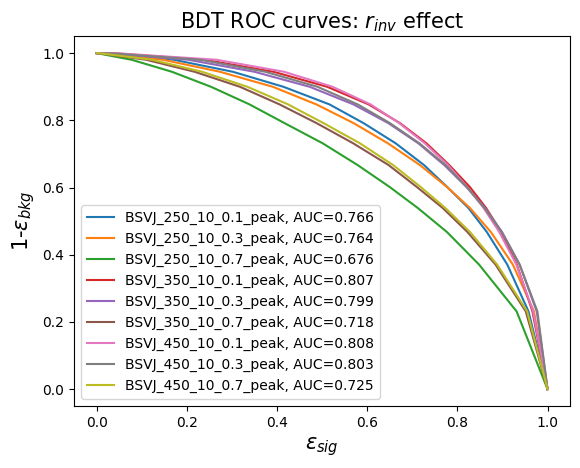

In [27]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
for i in (3,4,5,9,10,11,15,16,17):
    AUC =auc(sig_rinv_eff[lab_sig_rinv[i]], np.ones_like(qcd_eff)-qcd_eff)
    plt.plot(sig_rinv_eff[lab_sig_rinv[i]], np.ones_like(qcd_eff)-qcd_eff, label=lab_sig_rinv[i]+', AUC={:.3f}'.format(AUC))
    plt.legend()
plt.xlabel('$\epsilon_{sig}$', fontsize=15)
plt.ylabel('1-$\epsilon_{bkg}$', fontsize=15)
plt.title('BDT ROC curves: $r_{inv}$ effect', fontsize=15)
plt.savefig('png/ddt/roc_rinveffect.png')

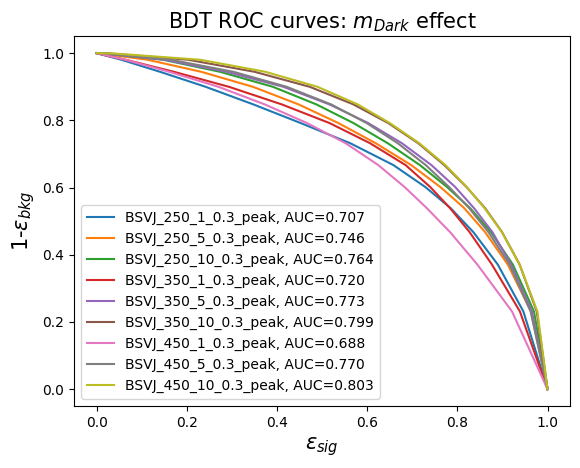

In [28]:
for i in (3,4,5,9,10,11,15,16,17):
    AUC =auc(sig_mdark_eff[lab_sig_mdark[i]], np.ones_like(qcd_eff)-qcd_eff)
    plt.plot(sig_mdark_eff[lab_sig_mdark[i]], np.ones_like(qcd_eff)-qcd_eff, label=lab_sig_mdark[i]+', AUC={:.3f}'.format(AUC))
    plt.legend()
plt.xlabel('$\epsilon_{sig}$', fontsize=15)
plt.ylabel('1-$\epsilon_{bkg}$', fontsize=15)
plt.title('BDT ROC curves: $m_{Dark}$ effect', fontsize=15)
plt.savefig('png/ddt/roc_mdarkeffect.png')

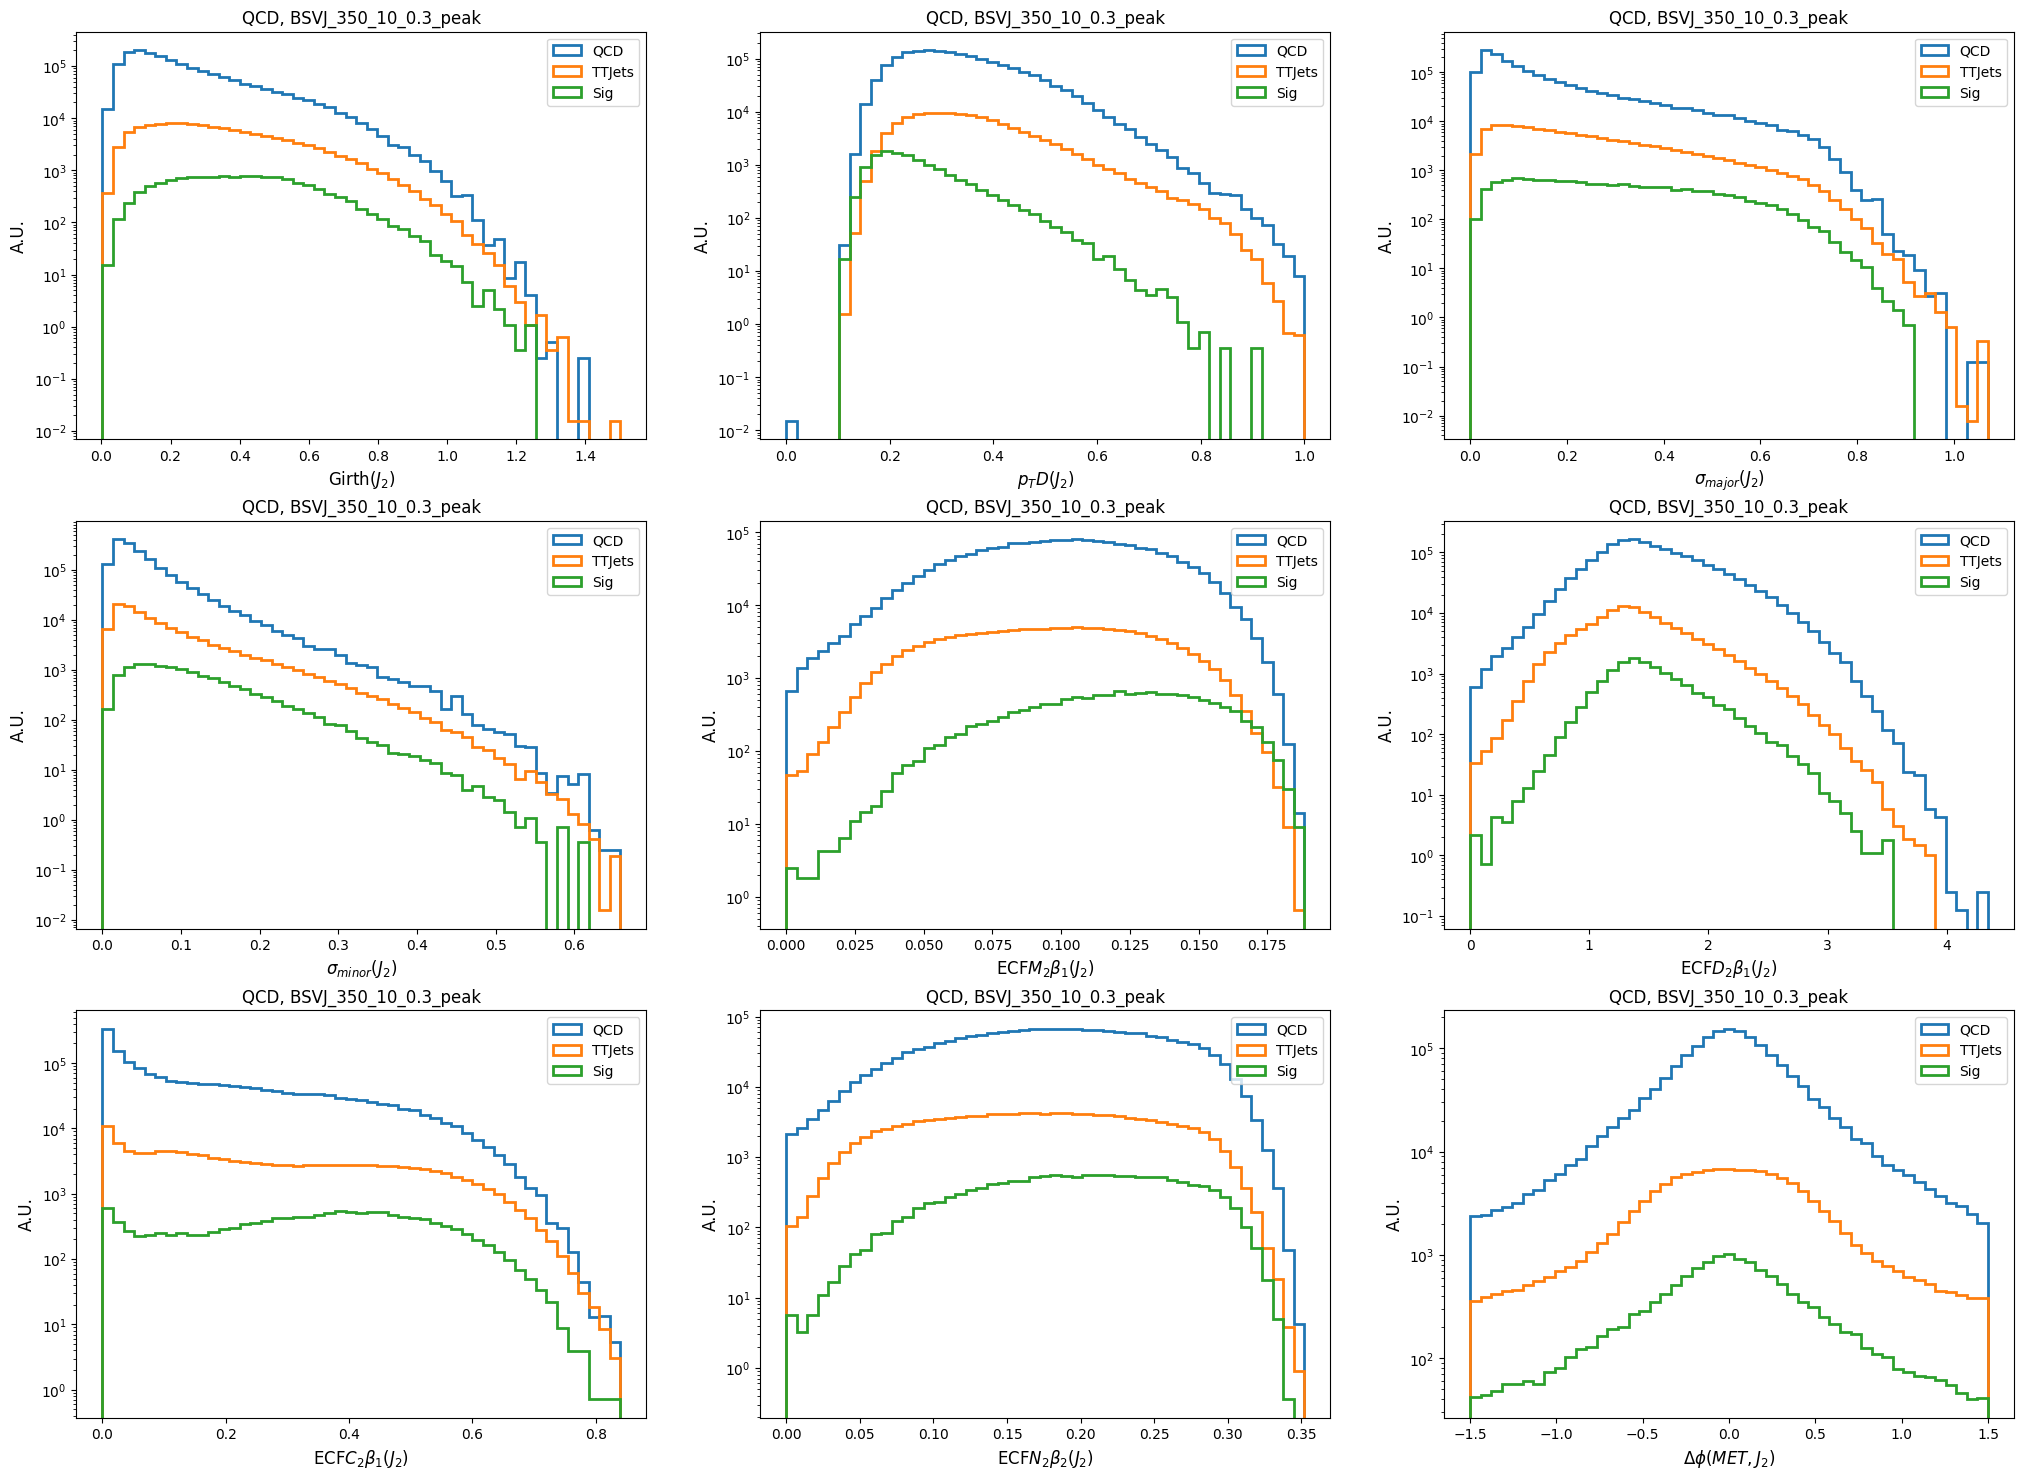

In [29]:
g=1
r=3
c=3
fig=plt.figure(figsize=(25,18))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
bdt_inputvars = ['Girth($J_2$)', '$p_TD(J_2)$', '$\sigma_{major}(J_2)$', '$\sigma_{minor}(J_2)$',r'ECF$M_{2}\beta_1(J_2)$',r'ECF$D_{2}\beta_1(J_2)$',r'ECF$C_{2}\beta_1(J_2)$',r'ECF$N_{2}\beta_2(J_2)$','$\Delta\phi(MET,J_2)$']


d=False
for i in bdt_features:
    fig.add_subplot(r, c, g)
    b=np.linspace(QCD[i].min(), QCD[i].max(),50)
    plt.hist(QCD[i], bins=b, weights=QCD_weights, histtype='step', linewidth=2, label='QCD', density=d)
    plt.hist(TTJets[i], bins=b, weights=TTJets_weights, histtype='step', linewidth=2, label='TTJets', density=d)
    plt.hist(signal[lab_sig_rinv[10]][i], bins=b, weights=sig_weight[lab_sig_rinv[10]], histtype='step', linewidth=2, label='Sig', density=d)
    plt.xlabel(bdt_inputvars[g-1], fontsize=12)
    plt.ylabel('A.U.', fontsize=12)
    plt.title('QCD, '+lab_sig_rinv[10], fontsize=12)
    plt.legend()
    plt.yscale('log')
    g+=1
plt.savefig('png/ddt/bdt_inputvar.png')

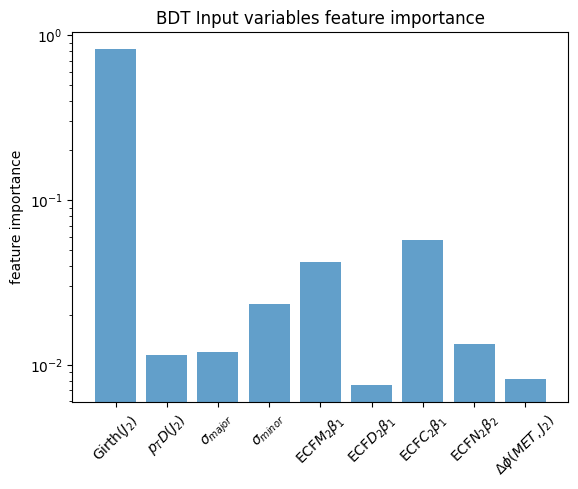

In [30]:
feature_important = xgb_model.feature_importances_
values=[v for i,v in enumerate(feature_important)]

bdt_inputvars = ['Girth($J_2$)', '$p_TD(J_2)$', '$\sigma_{major}$', '$\sigma_{minor}$',r'ECF$M_{2}\beta_1$',r'ECF$D_{2}\beta_1$',r'ECF$C_{2}\beta_1$',r'ECF$N_{2}\beta_2$','$\Delta\phi(MET,J_2)$']
a=plt.bar(bdt_inputvars, values, alpha=0.7)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('BDT Input variables feature importance')
plt.ylabel('feature importance')
plt.savefig('png/ddt/feature_importance.png')


In [87]:
def ROC_curve(data, w, var, var_min, var_max):
    #print(var_min)
    general_cut=(data[var]>var_min)
    
    b=np.linspace(data[var][general_cut].min(), data[var][general_cut].max(),50)
    hist_general=plt.hist(data[var][general_cut], weights=w[general_cut], bins=b)
    tot = sum(hist_general[0])# * (s1[1][1:]-s1[1][:-1]))    
    var_cut = np.linspace(var_min, var_max,30)
    eff=[]
    for i in range(30):
        sr_cut=(data[var]>var_cut[i])
        hist_cut=plt.hist(data[var][sr_cut], weights=w[sr_cut], bins=b)
        single_eff = sum(hist_cut[0])     
        eff.append(single_eff/tot)

    plt.close()
    return eff

In [ ]:
signal.keys()

In [117]:
qcd_eff_girth =ROC_curve(QCD, QCD['weight'], 'girth', 0, 1.5)
    

sig_rinv_eff  = {}
sig_mdark_eff  = {}

lab_sig_rinv = ['BSVJ_'+str(i)+'_10_'+str(j)+'_peak' for i in np.arange(200,560,50) for j in ('0.1','0.3','0.7')]
lab_sig_mdark = ['BSVJ_'+str(i)+'_'+str(j)+'_0.3_peak' for i in np.arange(200,560,50) for j in ('1','5','10')]
num_rinv=0
num_mdark=0
for k in range(3):
    for i in range(7):
        sig_rinv_eff[lab_sig_rinv[3*i+k]]   = ROC_curve(signal[lab_sig_rinv[3*i+k]], signal[lab_sig_rinv[3*i+k]]['weight'], 'girth', 0, 1.5)
        num_rinv+=1
        
for k in range(3):
    for i in range(7):        
        sig_mdark_eff[lab_sig_mdark[3*i+k]] = ROC_curve(signal[lab_sig_mdark[3*i+k]], signal[lab_sig_mdark[3*i+k]]['weight'], 'girth', 0, 1.5)
        num_mdark+=1
    

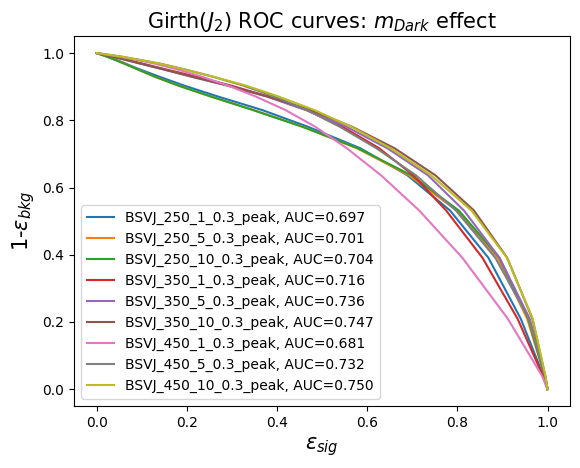

In [120]:
for i in (3,4,5,9,10,11,15,16,17):
    AUC =auc(sig_mdark_eff[lab_sig_mdark[i]], np.ones_like(qcd_eff_girth)-qcd_eff_girth)
    plt.plot(sig_mdark_eff[lab_sig_mdark[i]], np.ones_like(qcd_eff_girth)-qcd_eff_girth, label=lab_sig_mdark[i]+', AUC={:.3f}'.format(AUC))
    plt.legend()
plt.xlabel('$\epsilon_{sig}$', fontsize=15)
plt.ylabel('1-$\epsilon_{bkg}$', fontsize=15)
plt.title('Girth($J_2$) ROC curves: $m_{Dark}$ effect', fontsize=15)
plt.savefig('png/ddt/roc_girth_mdarkeffect.png')

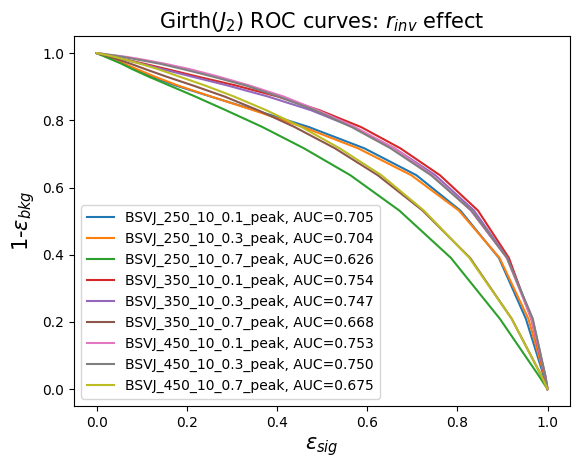

In [121]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
for i in (3,4,5,9,10,11,15,16,17):
    AUC =auc(sig_rinv_eff[lab_sig_rinv[i]], np.ones_like(qcd_eff_girth)-qcd_eff_girth)
    plt.plot(sig_rinv_eff[lab_sig_rinv[i]], np.ones_like(qcd_eff_girth)-qcd_eff_girth, label=lab_sig_rinv[i]+', AUC={:.3f}'.format(AUC))
    plt.legend()
plt.xlabel('$\epsilon_{sig}$', fontsize=15)
plt.ylabel('1-$\epsilon_{bkg}$', fontsize=15)
plt.title('Girth($J_2$) ROC curves: $r_{inv}$ effect', fontsize=15)
plt.savefig('png/ddt/roc_girth_rinveffect.png')

In [181]:
def metric_plots(sc, score, s):
    b=np.linspace(QCD['mt'][QCD[score]>sc].min(),1000,30)
    
    BKG = [ZJets['mt'][ZJets[score]>sc],             WJets['mt'][WJets[score]>sc],     TTJets['mt'][TTJets[score]>sc],     QCD['mt'][QCD[score]>sc]]
    BKG_Weights = [ZJets['weight'][ZJets[score]>sc], WJets['weight'][WJets[score]>sc], TTJets['weight'][TTJets[score]>sc], QCD['weight'][QCD[score]>sc]]
    
    val_of_bins_bkg, edges_of_bins_x2 = np.histogram(np.hstack(BKG), bins=b, weights=np.hstack(BKG_Weights))
    val_of_bins_sig, edges_of_bins_x1 = np.histogram(signal[s]['mt'][signal[s][score]>sc],bins=b, weights=signal[s]['weight'][signal[s][score]>sc])
    
    bincenter = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])
    metric = val_of_bins_sig / np.sqrt(val_of_bins_bkg)
    return metric, bincenter



'''Bincenter = {}
Ratio     = {}

cuts_ratio = [(0,0.4,0.42, 0.475), (0,0.4,0.43, 0.495), (0,4,5, 6)]



n=0
for rew in ('rho_bdtscore', 'mt_bdtscore'):
    Bincenter[rew] = {}
    Ratio[rew]     = {}
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        Ratio[rew][s]     = {}
        Bincenter[rew][s] = {}
        #n=0
        #for sc in (0.0, 0.4, 0.5, 0.6):
        for sc in cuts_ratio[n]:
            Ratio[rew][s][sc], Bincenter[rew][s][sc] = metric_plots(sc, rew, s)
    n+=1'''

color=['green','red','steelblue','black'] 
style=['P','o','*','p']
lab=[r'$\rho$-rew> ', '$M_T$-rew> ']
cuts = [(0.4,0.4,4), (0.42,0.43, 5),(0.475,0.495,6)]

for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
    n=0
    #for sc in (0.4, 0.5, 0.6):
    for sc in cuts:
        l=0
        '''for rew in ('rho_bdtscore', 'mt_bdtscore'):
            plt.plot(Bincenter[rew][s][sc], Ratio[rew][s][sc], style[l], label=lab[l]+str(sc), color=color[l])
            l+=1'''
        plt.plot(Bincenter['rho_bdtscore'][s][sc[0]], Ratio['rho_bdtscore'][s][sc[0]], style[0], label=r'$\rho$-rew> '+str(sc[0]), color=color[0])
        plt.plot(Bincenter['mt_bdtscore'][s][sc[1]], Ratio['mt_bdtscore'][s][sc[1]], style[1], label='$M_T$-rew> '+str(sc[1]), color=color[1])
        plt.plot(bincenter_ddt[sc[2]][s], ratio_ddt[sc[2]][s], style[2], label='$BDT^{DDT}$>0.'+str(sc[2]), color=color[2])
        l+=1
        plt.plot(Bincenter['rho_bdtscore'][s][0], Ratio['rho_bdtscore'][s][0], style[3], label='no BDT cut', color=color[3])
        plt.legend()
        plt.xlabel('$M_T(J_2)$', fontsize=15)  
        plt.ylabel(r'$S/\sqrt{B}$', fontsize=15)
        plt.title(s)
        plt.savefig('png/ddt/metrics/'+str(s)+'_0.'+str(sc[2])+'.png')
        plt.close()
    n+=1

In [176]:
Bincenter = {}
Ratio     = {}

cuts_ratio = [(0,0.4,0.42, 0.475), (0,0.4,0.43, 0.495), (0,4,5, 6)]
n=0
for rew in ('rho_bdtscore', 'mt_bdtscore'):    
    Bincenter[rew] = {}
    Ratio[rew]     = {}
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        Ratio[rew][s]     = {}
        Bincenter[rew][s] = {}
        #n=0
        #for sc in (0.0, 0.4, 0.5, 0.6):
        for sc in cuts_ratio[n]:
            Ratio[rew][s][sc], Bincenter[rew][s][sc] = metric_plots(sc, rew, s)
    n+=1
    
    
ratio_ddt        = {}
bincenter_ddt    = {}


for sc in (0,4,5,6):
    b=np.linspace(100, 1000, 30)

    BKG = [ZJets['mt'][BKG_score_ddt[sc]['ZJets']>0], WJets['mt'][BKG_score_ddt[sc]['WJets']>0], TTJets['mt'][BKG_score_ddt[sc]['TTJets']>0], QCD['mt'][BKG_score_ddt[sc]['QCD']>0]]
    BKG_Weights = [ZJets['weight'][BKG_score_ddt[sc]['ZJets']>0], WJets['weight'][BKG_score_ddt[sc]['WJets']>0], TTJets['weight'][BKG_score_ddt[sc]['TTJets']>0], QCD['weight'][BKG_score_ddt[sc]['QCD']>0]]
                                           

    val_of_bins_bkg, edges_of_bins_x2 = np.histogram(np.hstack(BKG), bins=b, weights=np.hstack(BKG_Weights))
    ratio_ddt[sc]    = {}
    bincenter_ddt[sc]= {}

    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        val_of_bins_sig, edges_of_bins_x1 = np.histogram(signal[s]['mt'][score_sig_ddt[sc][s]>0.0],bins=b, weights=signal[s]['weight'][score_sig_ddt[sc][s]>0.0])


        ratio_ddt[sc][s]     = val_of_bins_sig / np.sqrt(val_of_bins_bkg)
        bincenter_ddt[sc][s] = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])